# Graphics 

Gráfico 2D com uma métrica de viés
*  eixo x : métrica de viés 
*  eixo y : métrica tradicional 
*  cada ponto:  um par (modelos, extração).

In [1]:
#from src.model_analysis import *
from src.utils import load_pickle

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from src.utils import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
CLASSIFIERS = ['LR','DT','SVM','XGB','MLP','RF']
DATASETS = ['HE', 'WH', 'DV']
METRICS_CLASSIC = ['auc','f1_score']
METRICS_BIAS = ['fned', 'fped', 'subgroup']
METRICS = METRICS_CLASSIC + METRICS_BIAS
FEATURES =  ['tf', 'tfidf','glove', 'fastText',  'bert', 'roberta']

In [6]:
def count_wins(data):
    df_wins = pd.DataFrame()
    for clf_name in CLASSIFIERS:
        for met in METRICS:
            df = data.loc[data["classifier"] == clf_name].reset_index(drop=True)
            #get the feature with the best value
            if met in ["fned", "fped"]:                
                ft_win = df.loc[df[met]==df[met].min()]["feature"]#df.iloc[df[met].idxmin()]["feature"]
            else:
                ft_win = df.loc[df[met]==df[met].max()]["feature"]
            for ft in ft_win:
                new_row = {"classifier": clf_name, "feature":ft, "metric": met}
                df_wins = df_wins.append(new_row, ignore_index=True)
    return df_wins

# Get the results 
def get_results_dataset(dataset_name = "HE"):
    # dictionary for save all features 
    df_results = pd.DataFrame()
    path = f"results/{dataset_name}/classifiers/metrics_average.csv"
    df = pd.read_csv(path)

    #  Split column of lists into two new columns
    df[['classifier', 'feature']] = df.model.str.split("_", expand = True)
    
    #remove sufix
    df.columns = df.columns.str.replace(r'_mean', "")
        
    return df 

In [7]:
def plot_pars(data, metric1="subgroup", metric2="auc",path="fig.png", title="dataset", labelsx="x", labely="y"):
    # features = results.keys()
    plt.figure(figsize=(7, 5), dpi=300)
    fig = sns.scatterplot(data=data, x=metric1, y=metric2, hue="feature",style="feature", legend=True)  # hue="classifier",

    # data = data.loc(data.classifier!="SVM_rbf")

    for line in range(0,data.shape[0]):
        fig.text(data[metric1][line], data[metric2][line]+0.001, 
        str(data.classifier[line]), horizontalalignment='left', 
        size='x-small', color='black')#, weight='semibold')

        # f"{str(data.feature[line]),str(data.classifier[line])}", horizontalalignment='left', 
    # plt.title(title)
    # Set x-axis label
    plt.xlabel(labelsx)
    # Set y-axis label
    plt.ylabel(labely)
    if metric1=="subgroup":
        plt.xlim(.481,.58)
        # plt.xticks([(i/1000) for i in range(450,600, 5)])
    else:
        plt.xlim(0,.3)
        # plt.xticks([ i/100 for i in range(0,60, 5)])
    if metric2=="auc":
        plt.ylim(.55,0.95)
    else:
        plt.ylim(0.45,.9)  

    handles, labels = fig.get_legend_handles_labels()
    fig.legend(handles, labels, loc=2, bbox_to_anchor=(1.03, 1), borderaxespad=0.,  fontsize = 'xx-small')#'upper right'
    # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.5, 1.05),
    #       fancybox=True, shadow=True, ncol=5)
    plt.tight_layout()

    path_fold = "/".join(list(path.split('/')[0:-1])) 
    print(path_fold)
    if not check_exist(path_fold):
        create_dir(path_fold)

    plt.savefig(path)
    plt.show()
    return 

def plot_wins(data,title="dataset", ax = None, axes=None, axes_values=False):
    
    
    data = data.replace({'metric': {'f1_score':'f1'}})
    data = data.replace({'metric': {'subgroup':'sub'}})

    # print(data)
    # plt.figure(figsize=(8,6))
    sns.set_theme(style="whitegrid")
    if axes_values:
        a = sns.countplot(data=data, x="feature", hue="metric", ax=axes[ax], order=FEATURES)#, order=FEATURES
        
        for container in a.containers:
            a.bar_label(container)
        # abs_values = data['metric'].value_counts(ascending=False).values
        # a.bar_label(container=a.containers[0], labels=abs_values)
        #sns.countplot(data=data, x="feature", hue="metric", ax=axes[ax], order=FEATURES)
    else:
        ax = sns.countplot(data=data, x="metric", hue="feature")
        # abs_values = data['metric'].value_counts(ascending=False).values
        # print(abs_values)
        # set the minor ticks
        


        #sns.countplot(data=data, x="feature", hue="metric", order=FEATURES)        
        plt.xlabel("FEATURE")
        plt.ylabel("COUNT WINS")
        plt.title(title)
        plt.legend(loc='upper right', bbox_to_anchor=(1.29, 1)) 
        plt.grid()  


def plot_wins_dataset(data_dict, path="fig.png"):
    n = len(data_dict.keys())

    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    fig.tight_layout(pad=1.0)

    for idx, (data_name, data) in enumerate(data_dict.items()):
        df_wins = count_wins(data)
        title = f"{data_name} DATASET"
        axes_values = True if n > 1 else False
        plot_wins(df_wins,title=title, ax = idx, axes=axes, axes_values= axes_values)
        
              
        axes[idx].set_xlabel("FEATURE")
        axes[idx].set_ylabel("COUNT WINS")
        axes[idx].set_title(title)
        axes[idx].legend([],[], frameon=False)
        axes[idx].set_ylim(0,7)
    # plt.ylim(0.4,.7)
    handles, labels = axes[0].get_legend_handles_labels()
    # fig.legend(handles, labels,title="METRICS", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)#'upper right'
    fig.legend(handles, labels,title="METRICS", loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.savefig(path, bbox_inches='tight')
    plt.show()


def plot_pars_metrics(dataset_name, data, path=None):
    if path is None:
        path = f"results/{dataset_name}/plots/"

    if not (check_exist(path)):
        create_dir(path)
        
    for met_cla in METRICS_CLASSIC:
        for met_bias in METRICS_BIAS:
            plot_pars(data, metric1=met_bias, metrics2=met_cla, path=f"{path}{met_bias}_{met_cla}", title=f"{dataset_name} dataset", labelsx=met_bias.upper(), labely=met_cla.upper())

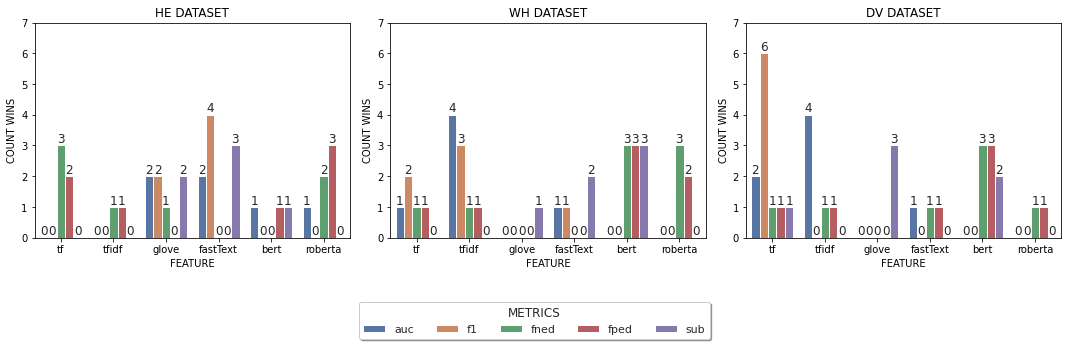

In [8]:
# get results 
results ={}
for dataset in DATASETS:
    results[dataset] = get_results_dataset(dataset_name = dataset)
 
plot_wins_dataset(results,path="results/plot_wins_v2.png")


results/HE/plots


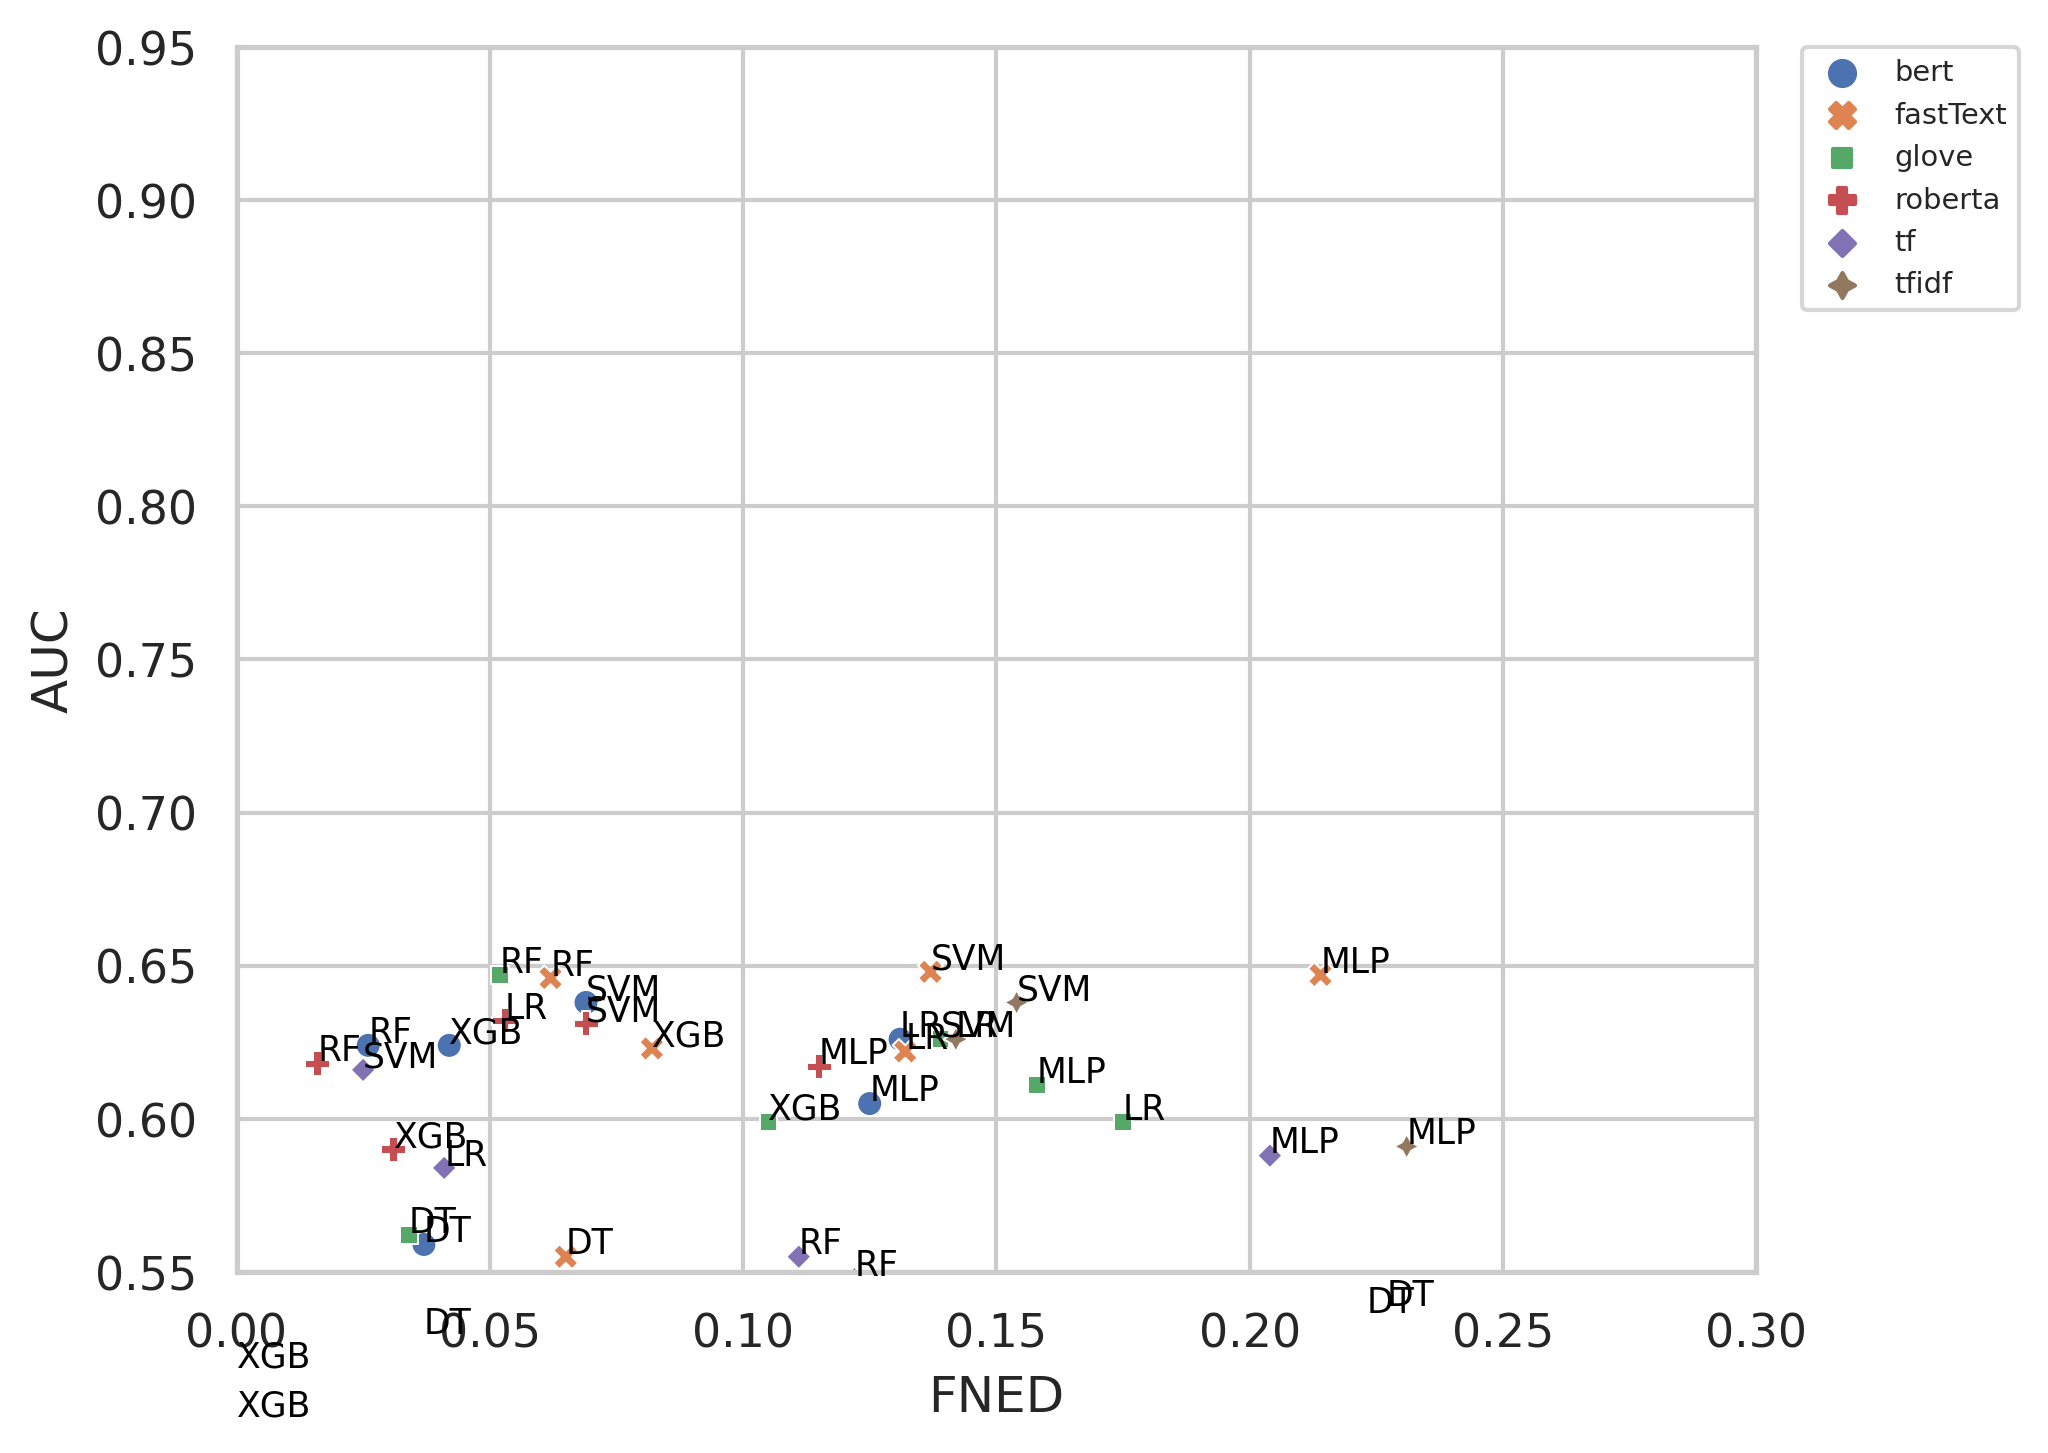

results/HE/plots


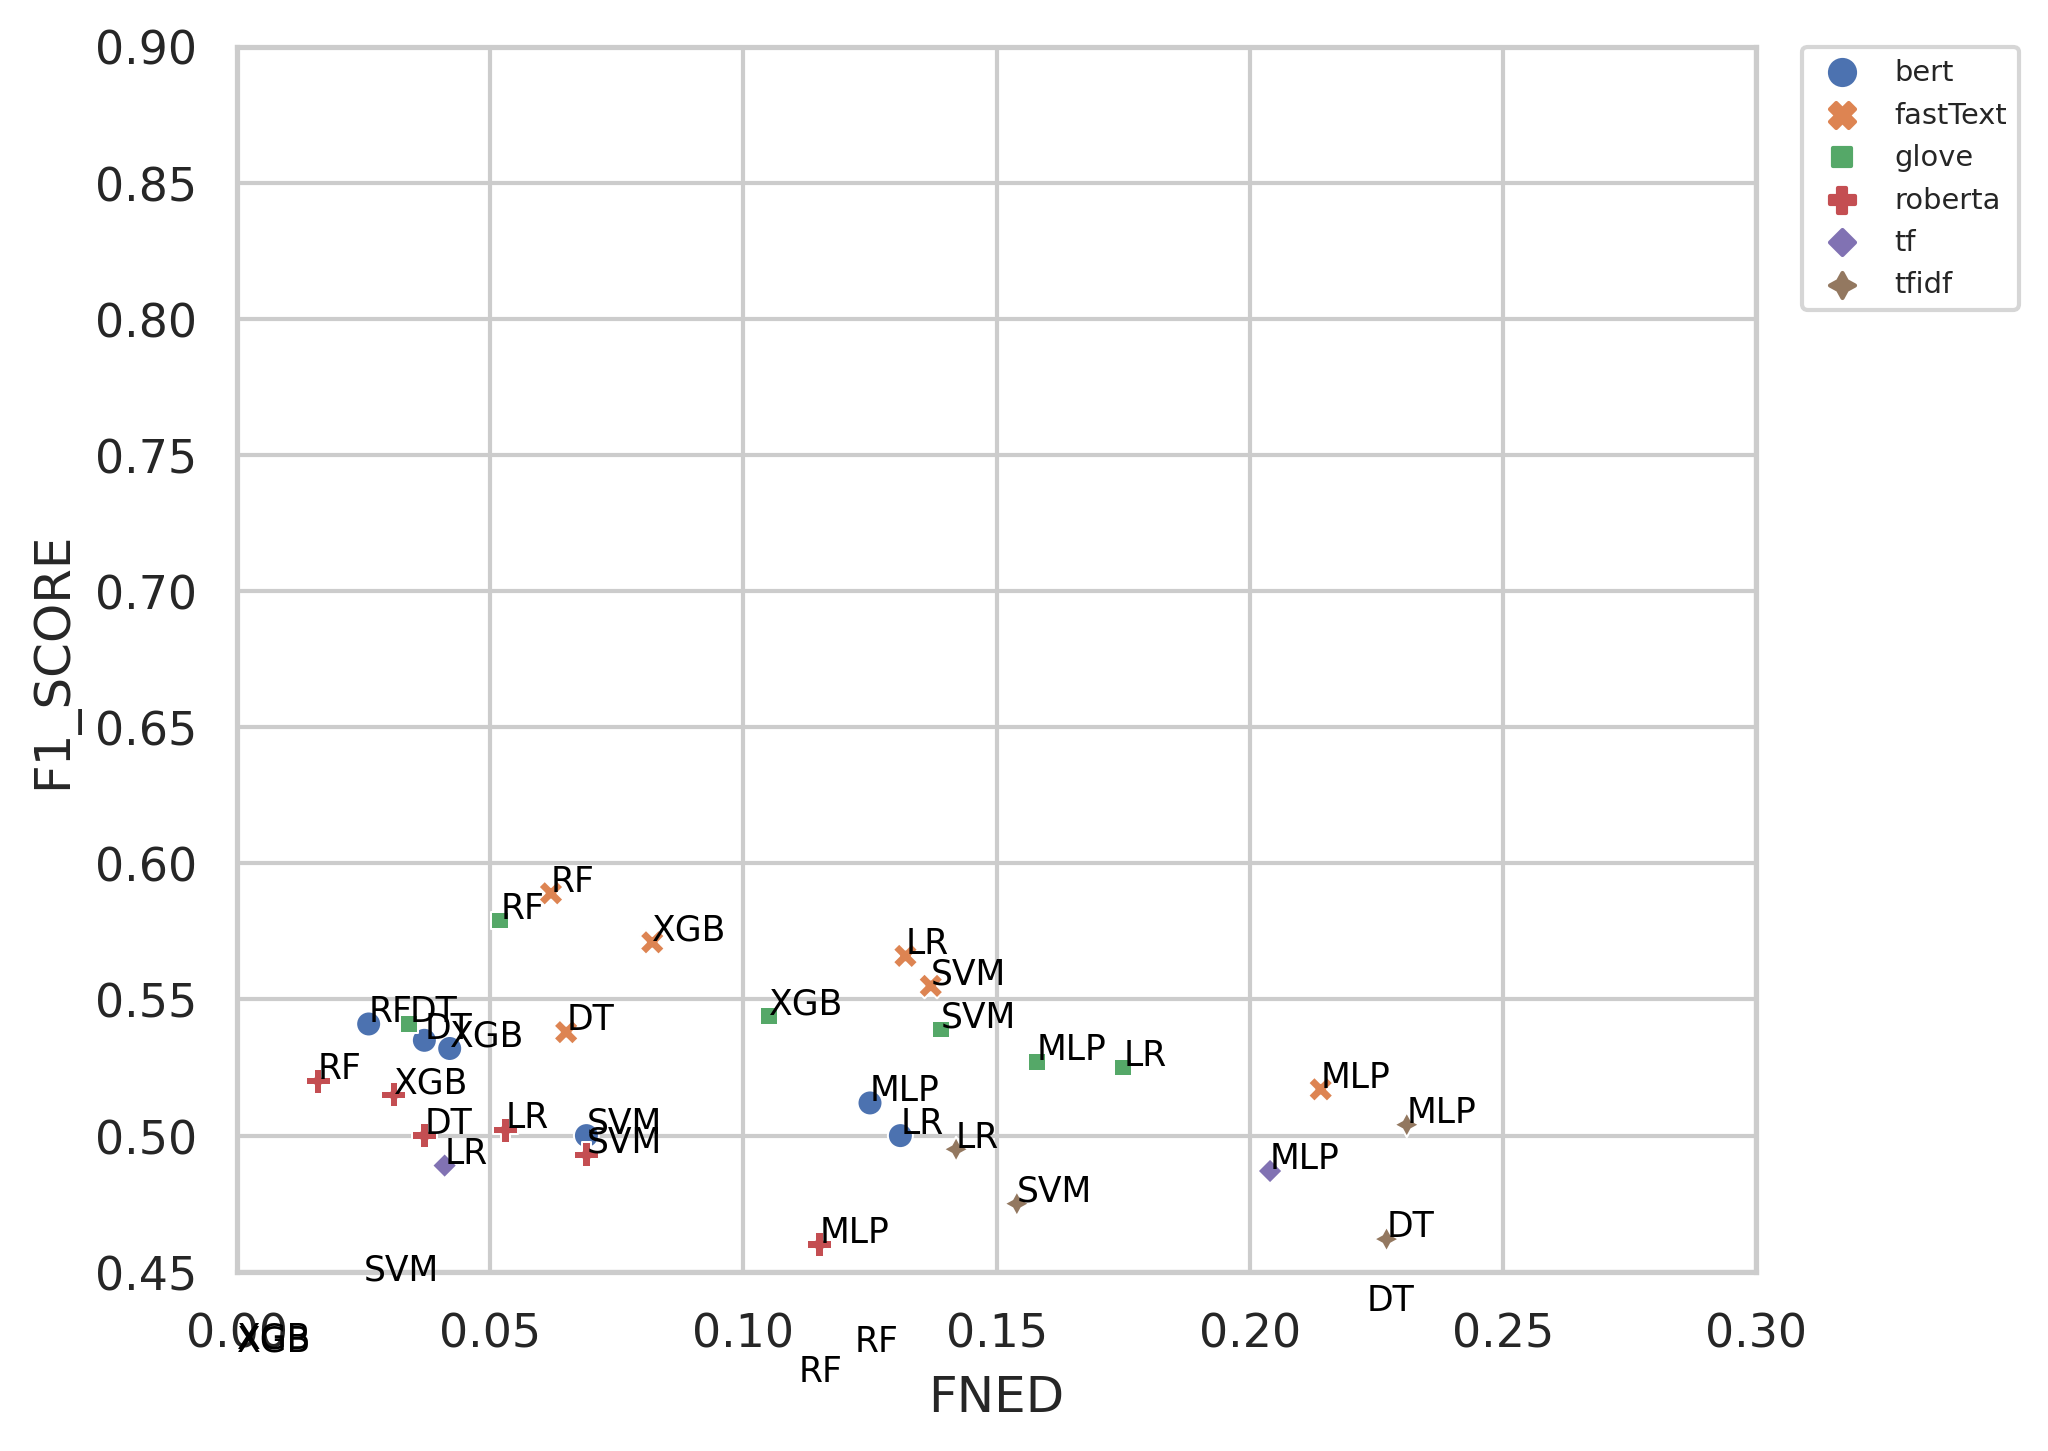

results/HE/plots


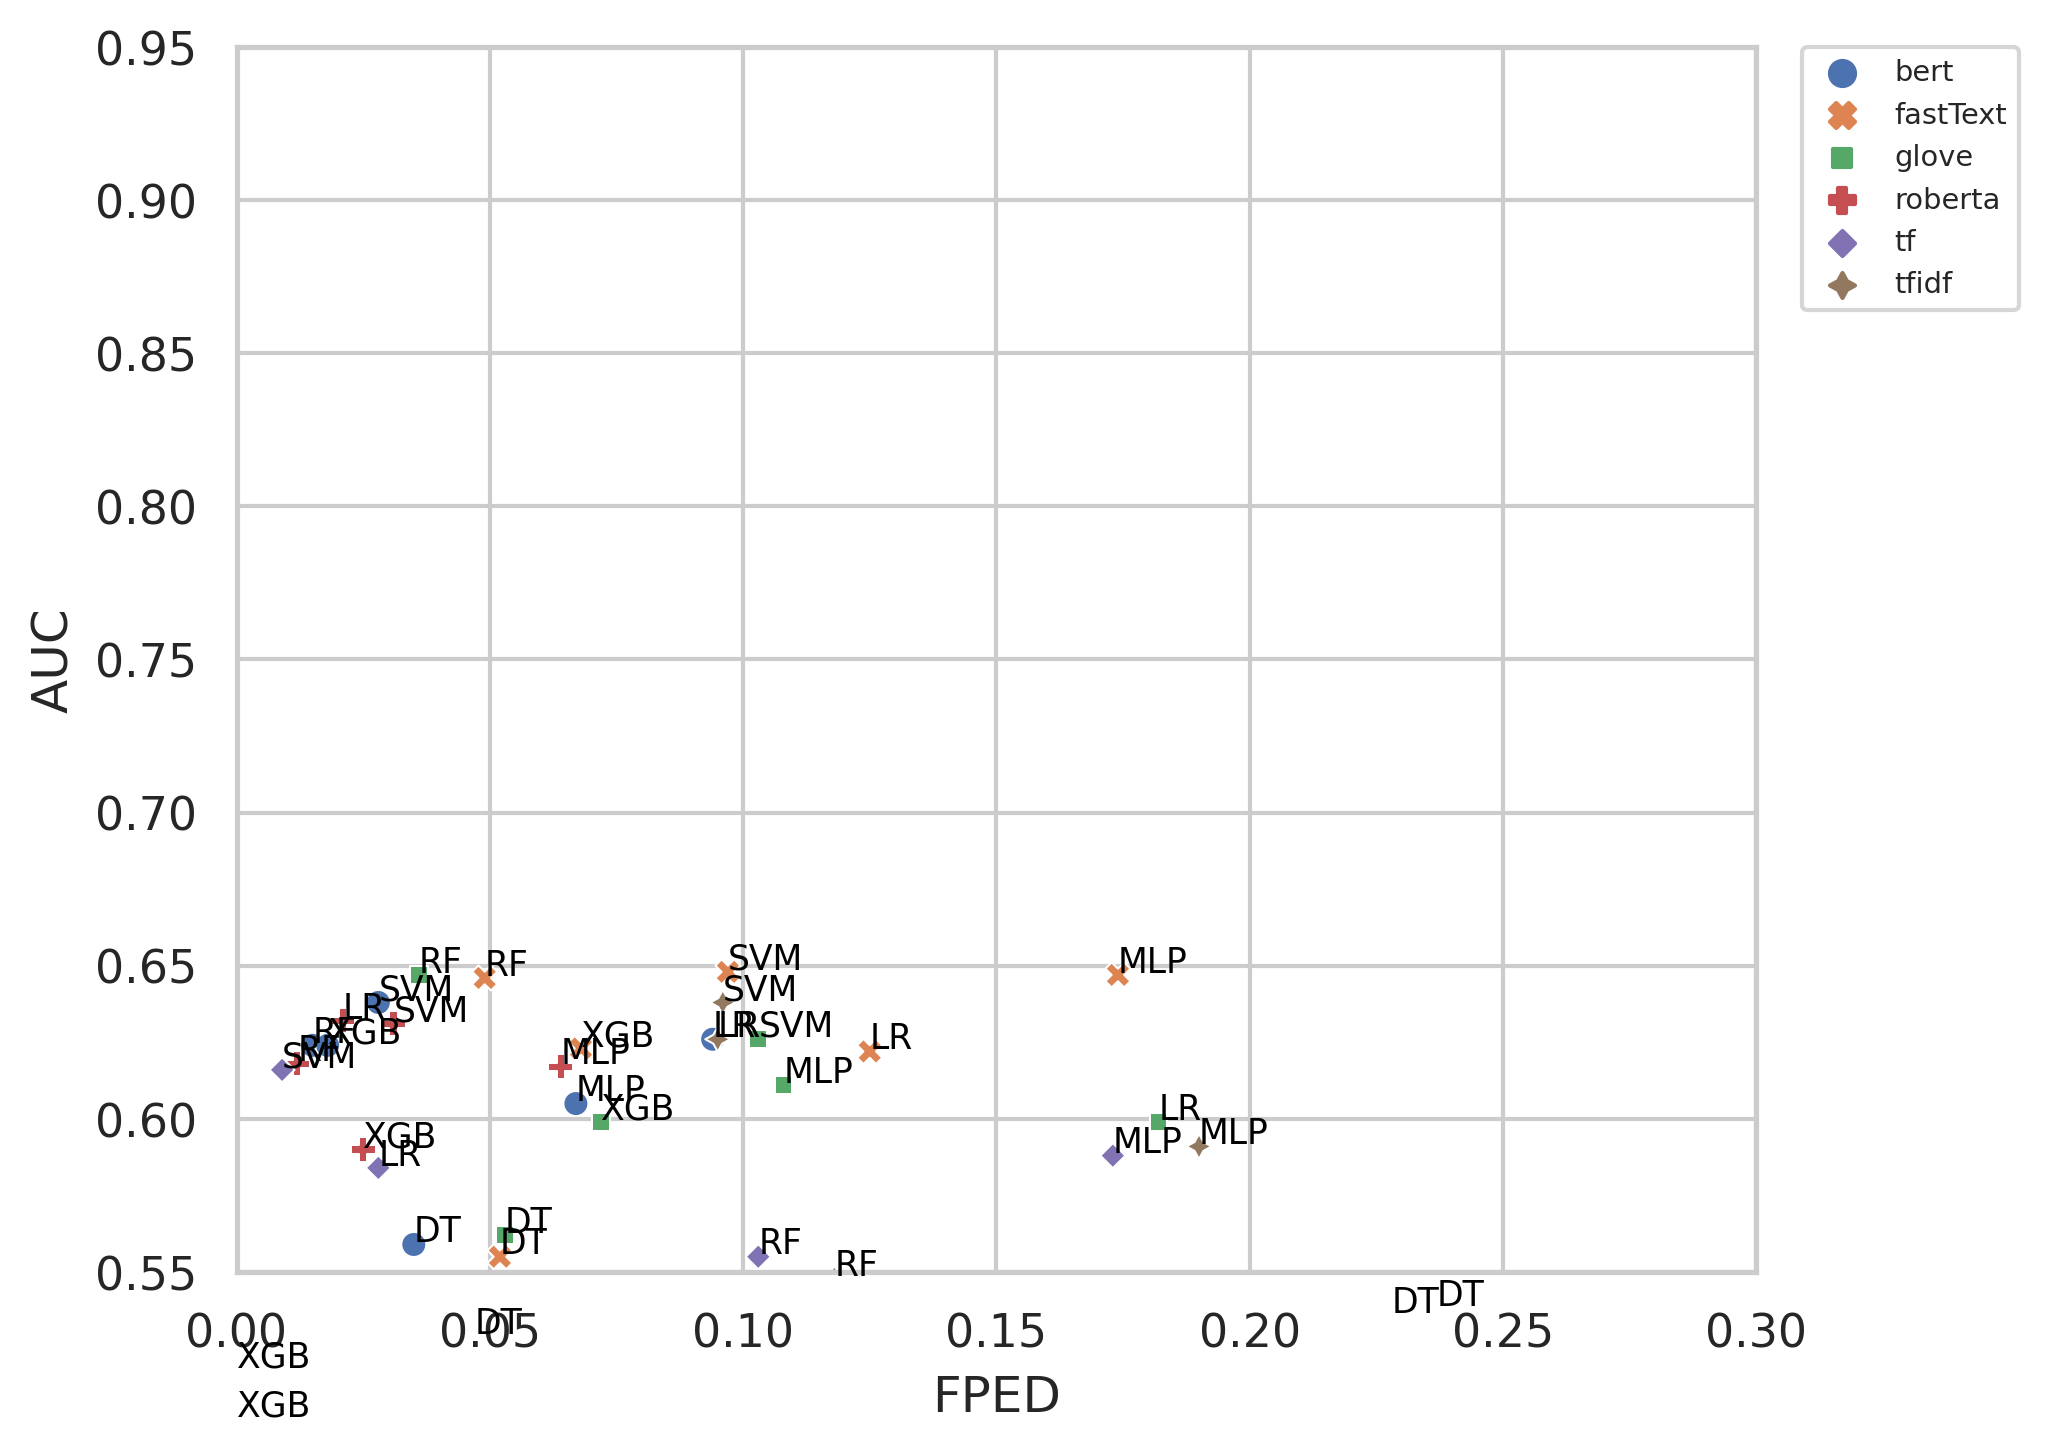

results/HE/plots


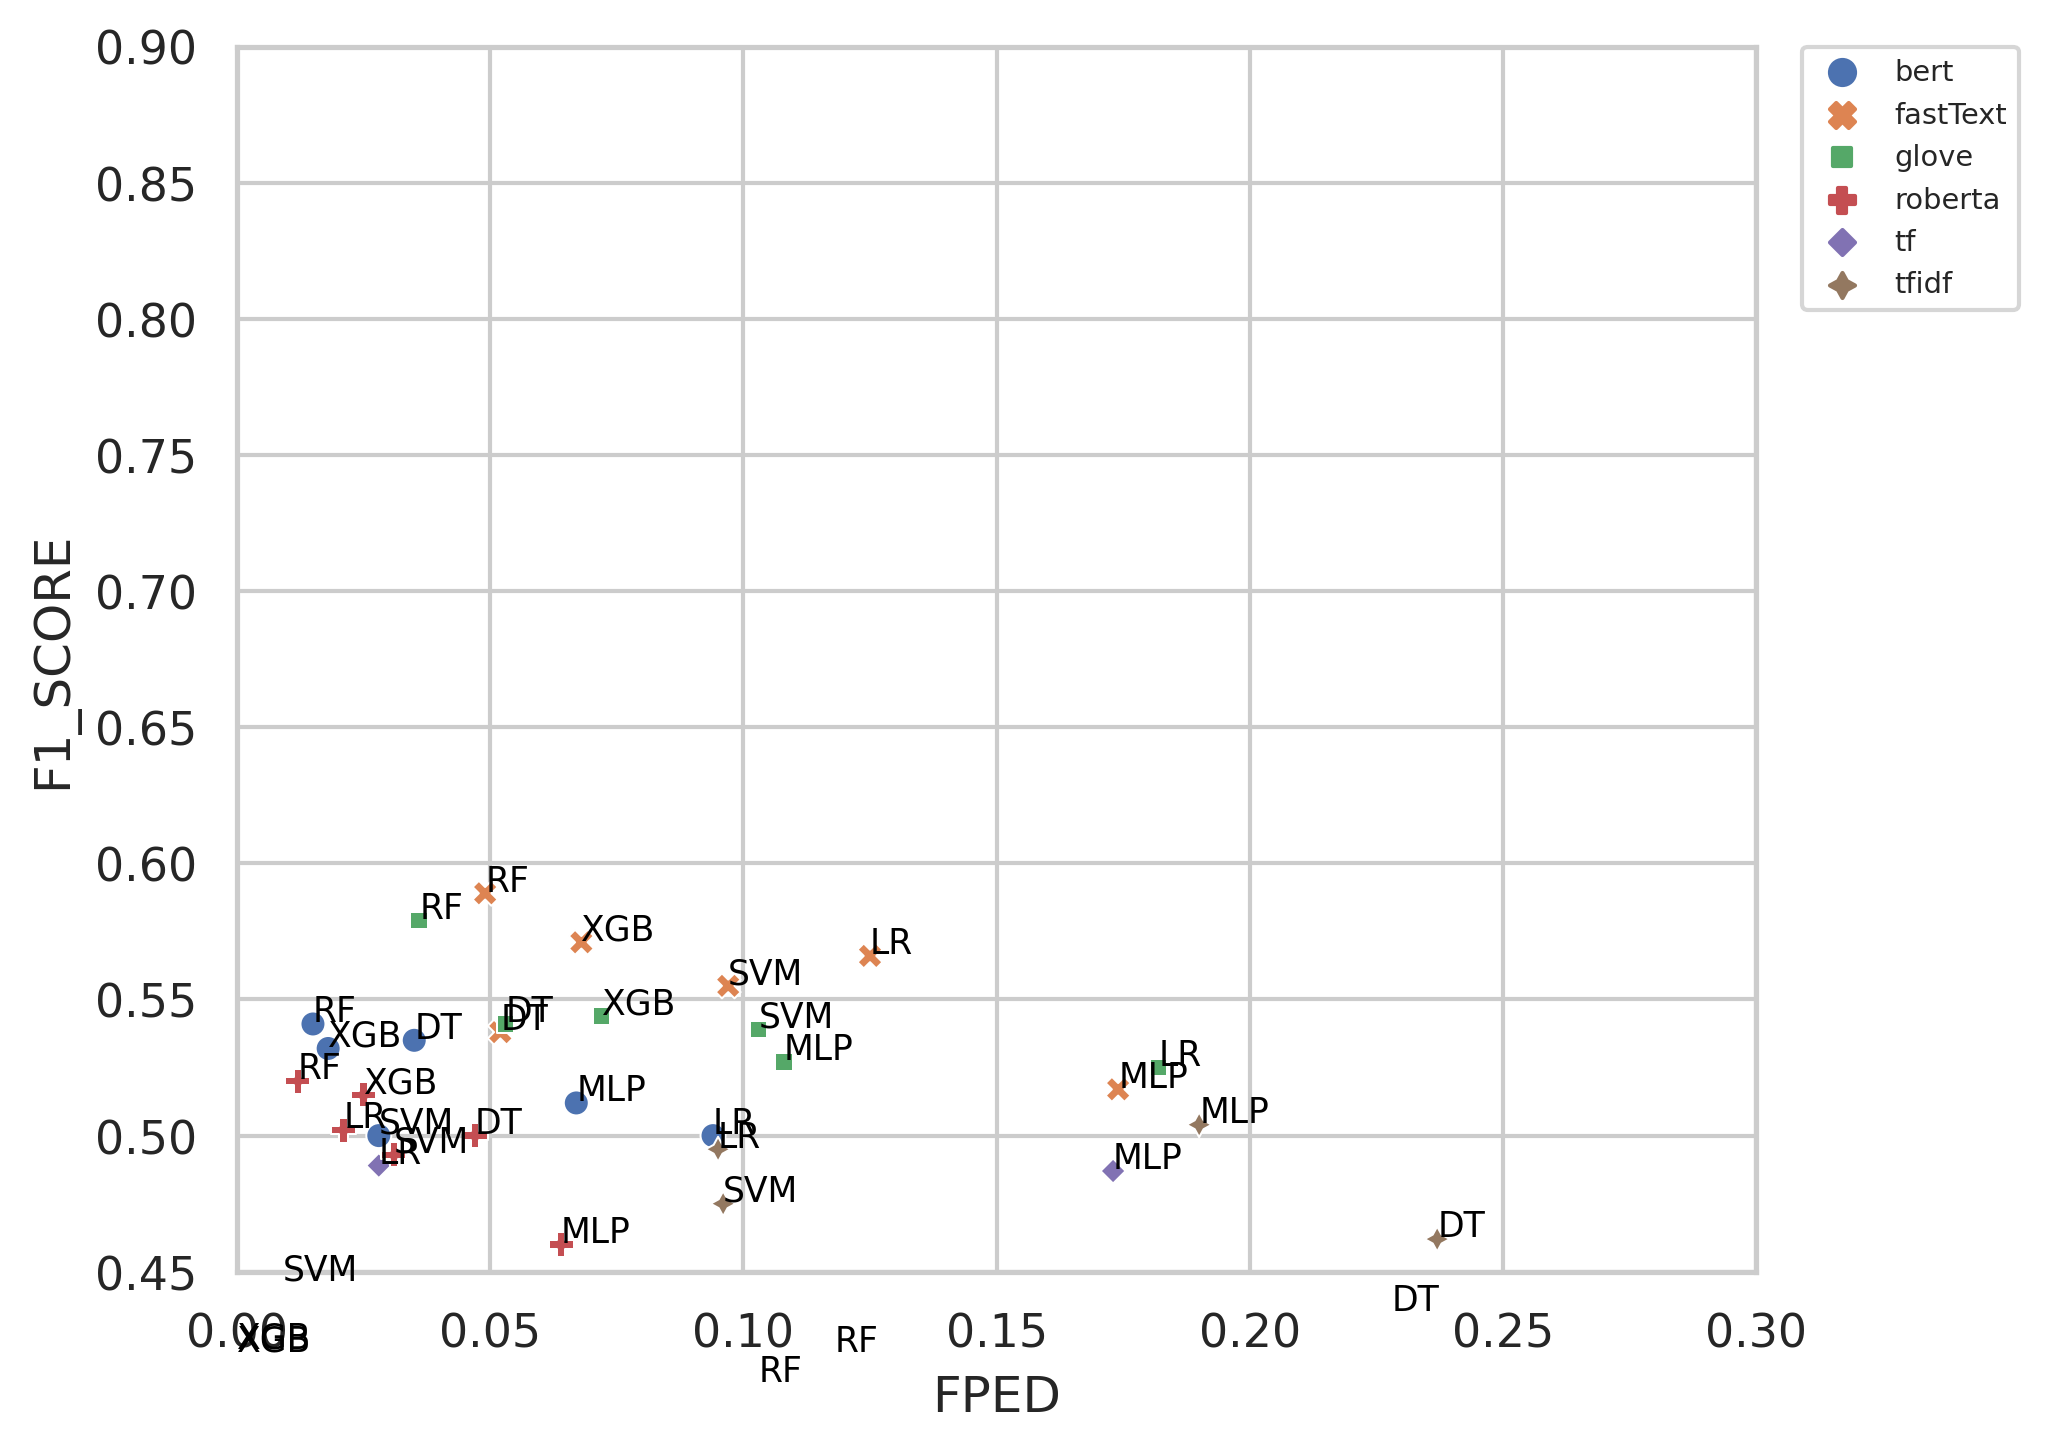

results/HE/plots


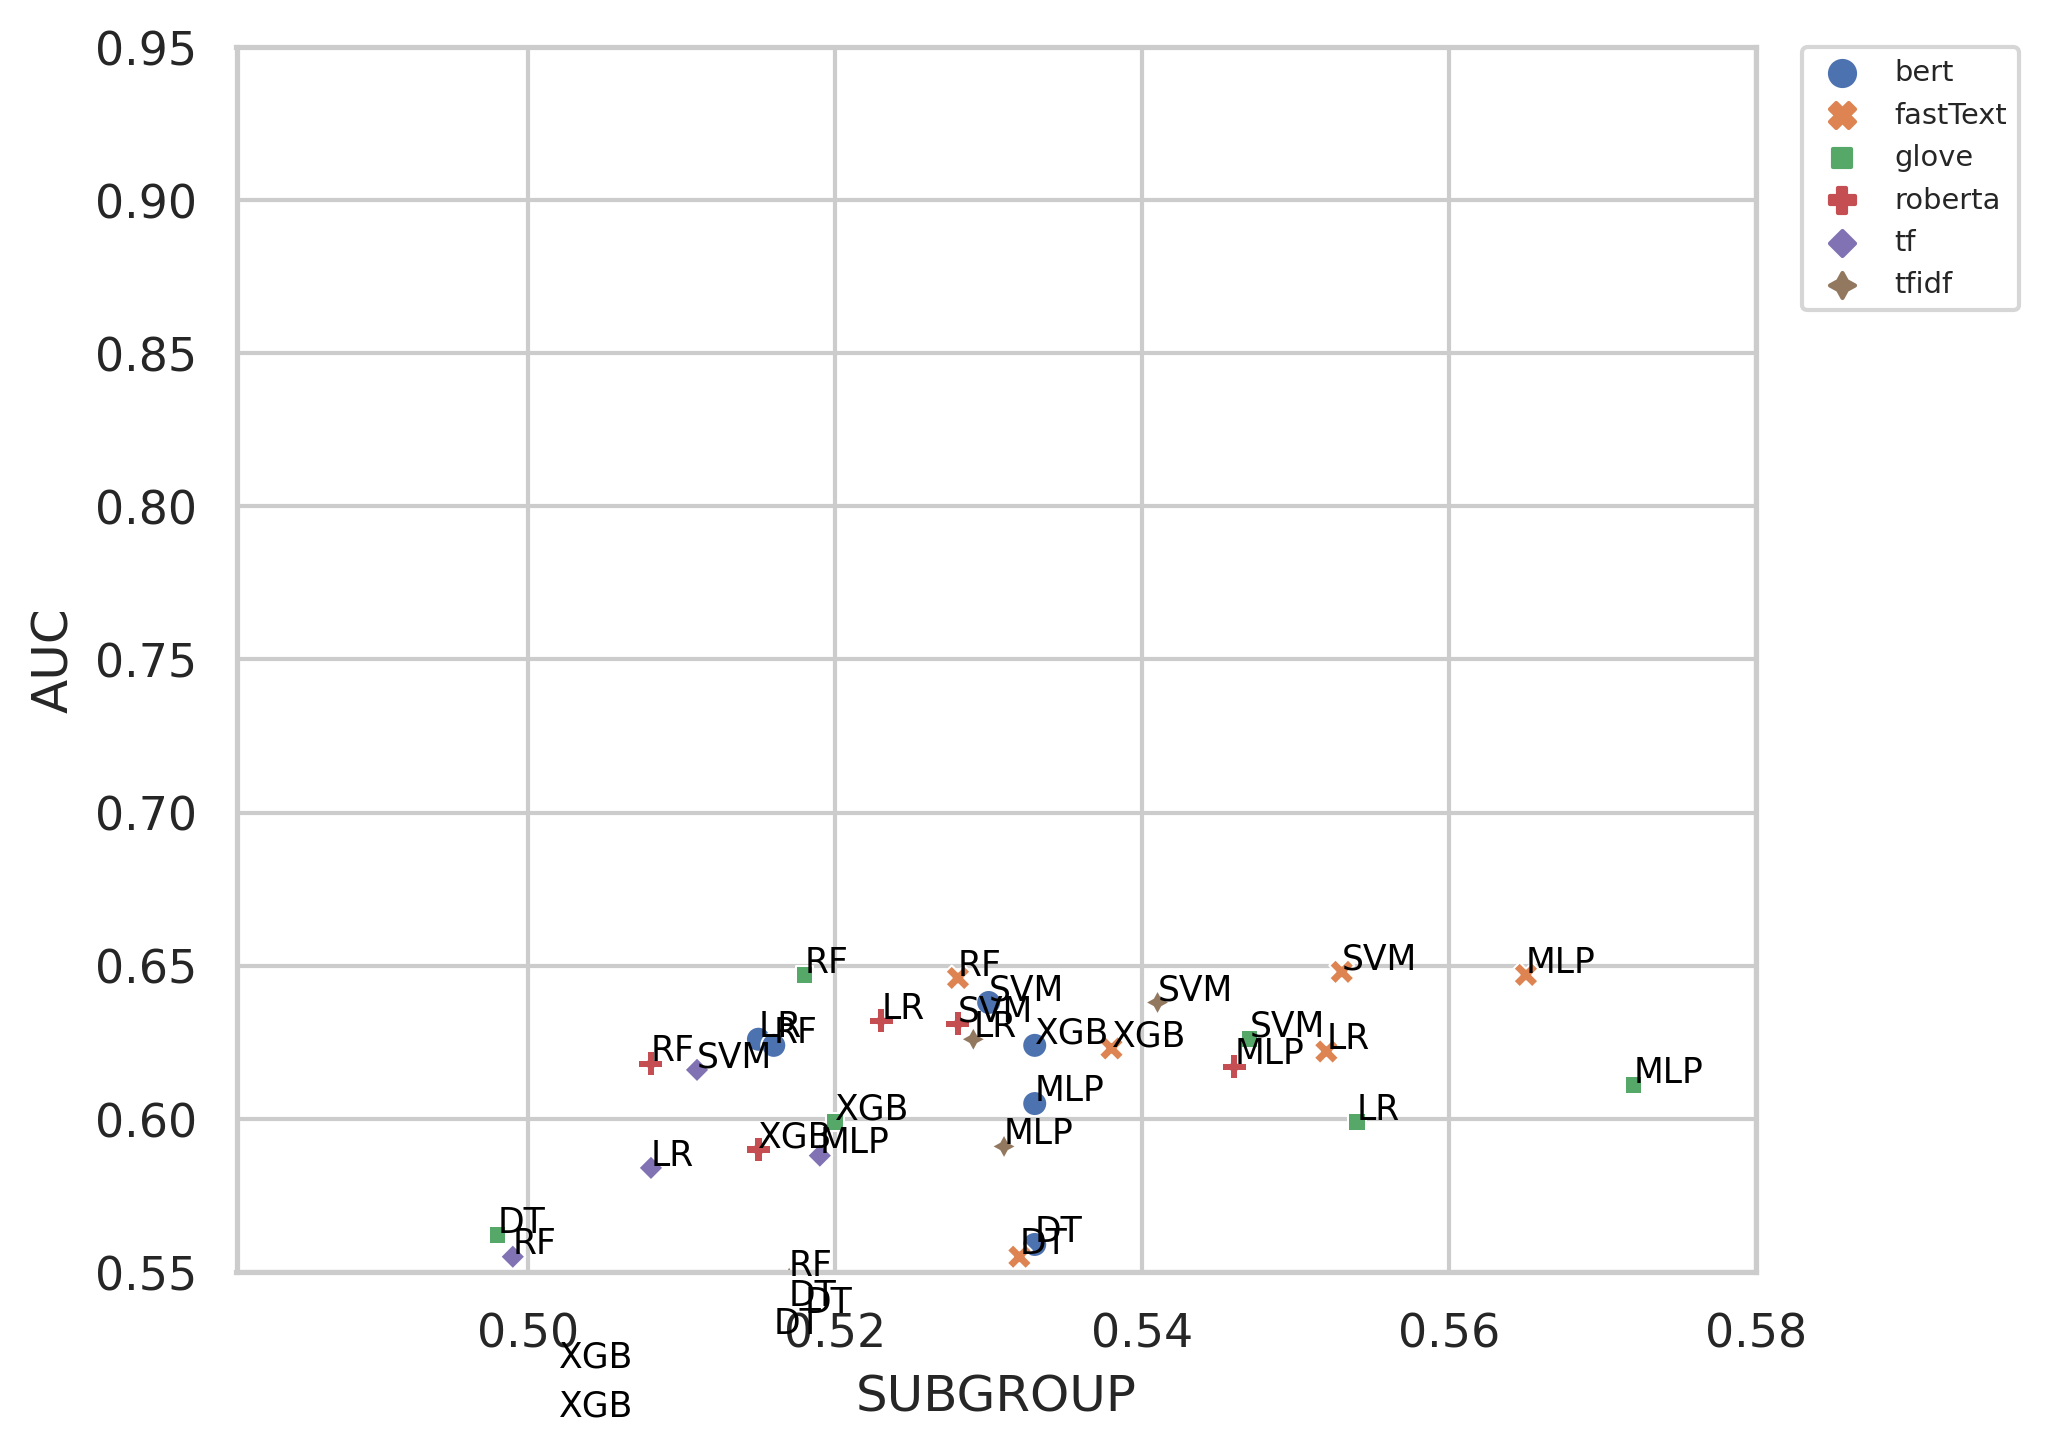

results/HE/plots


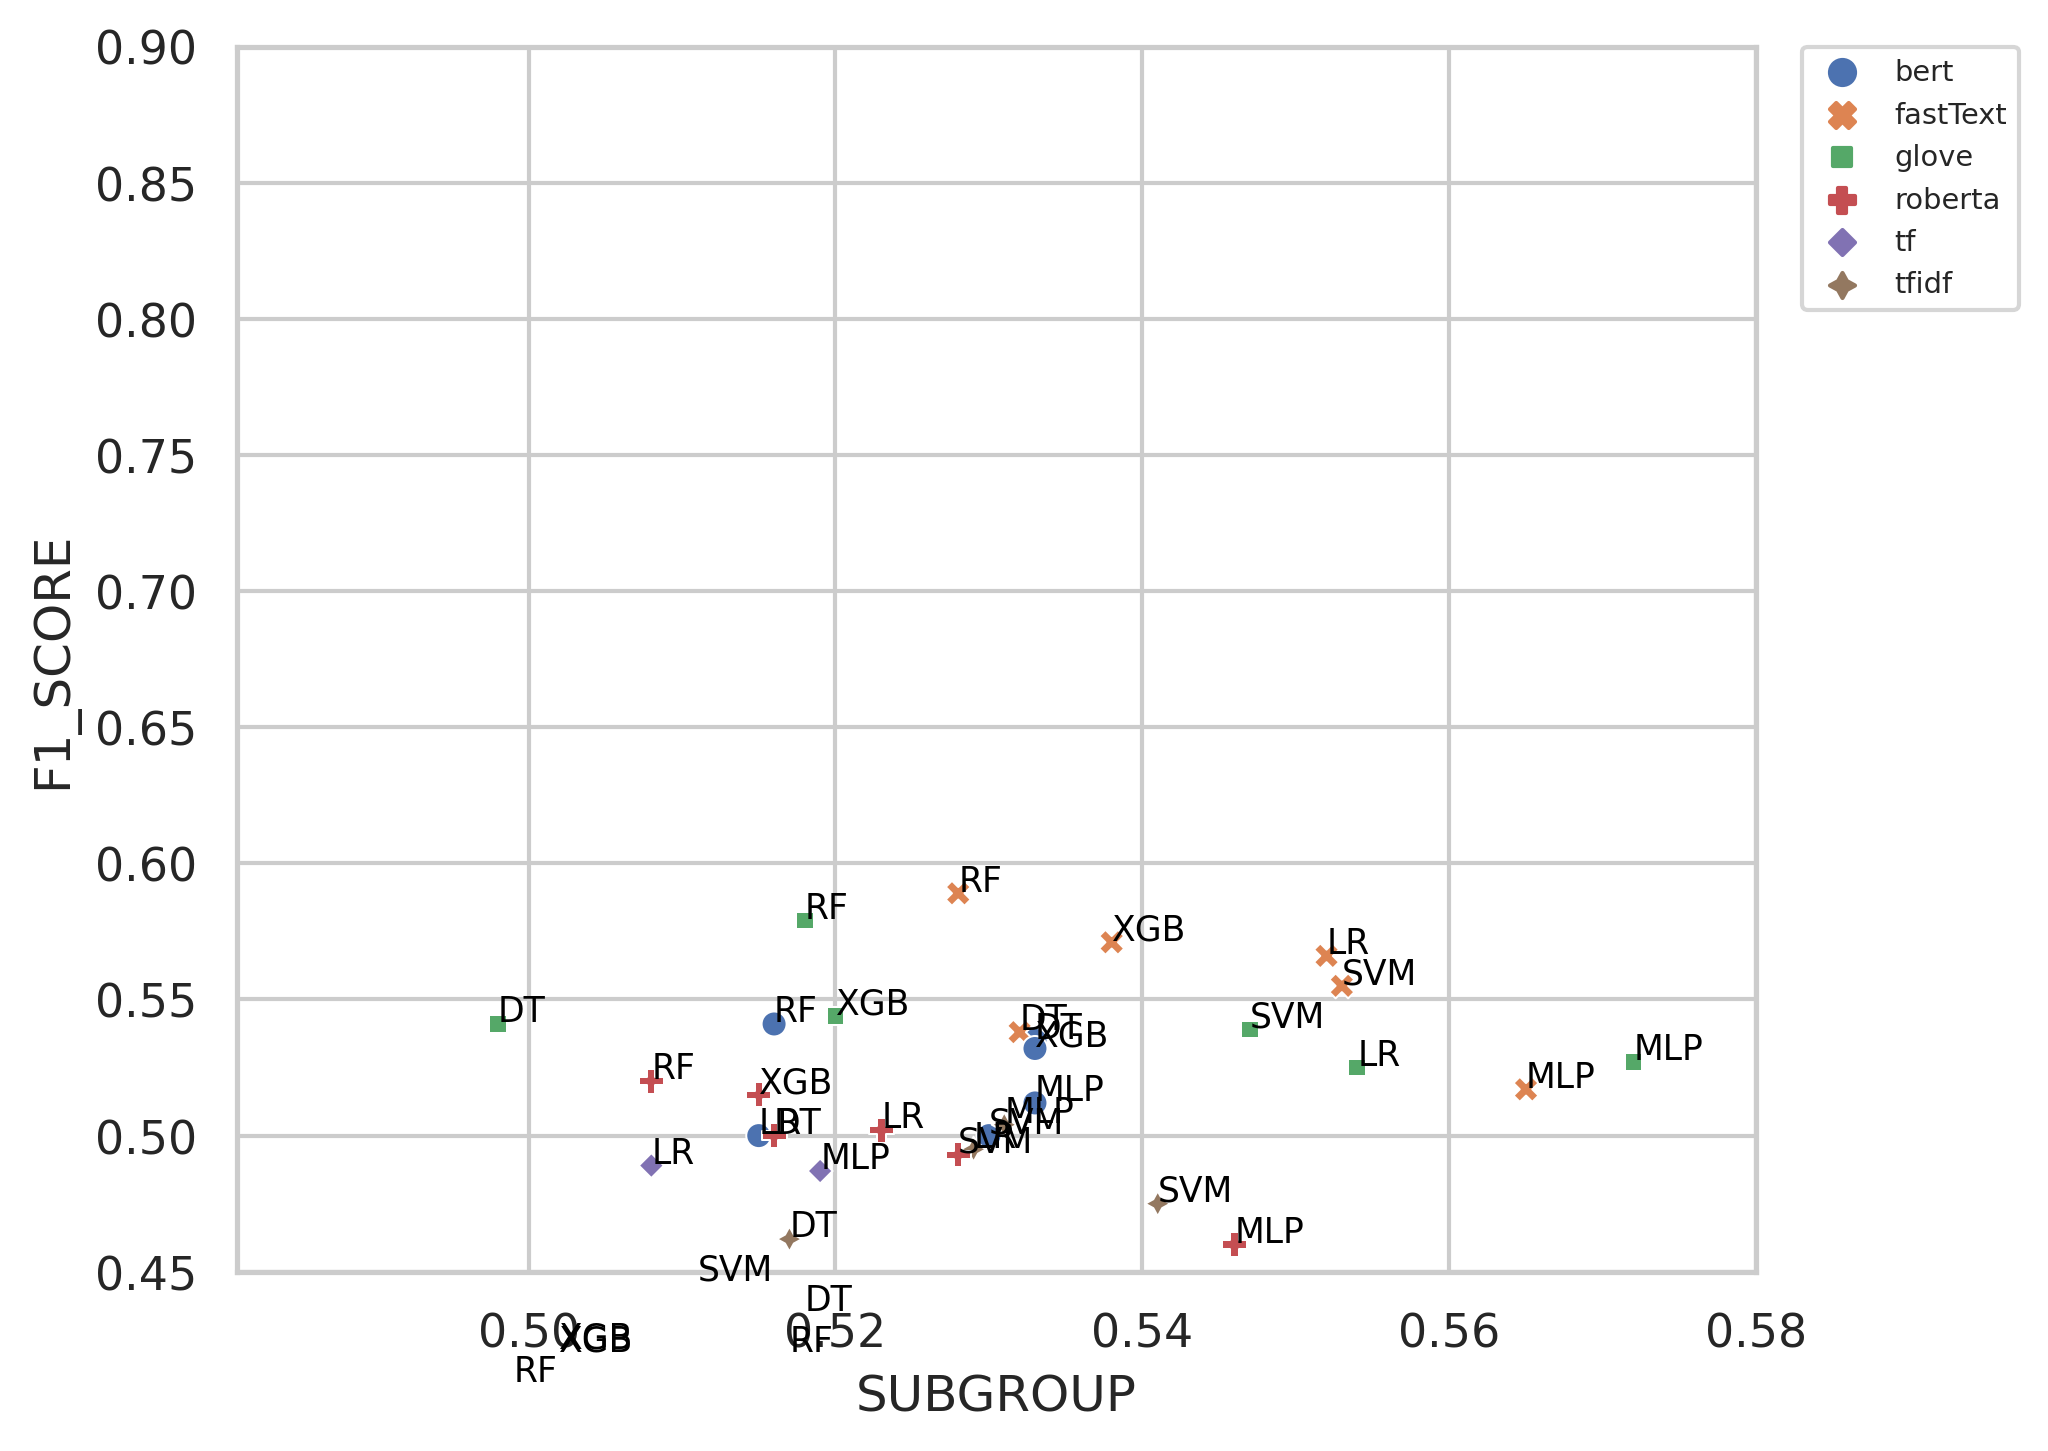

results/WH/plots


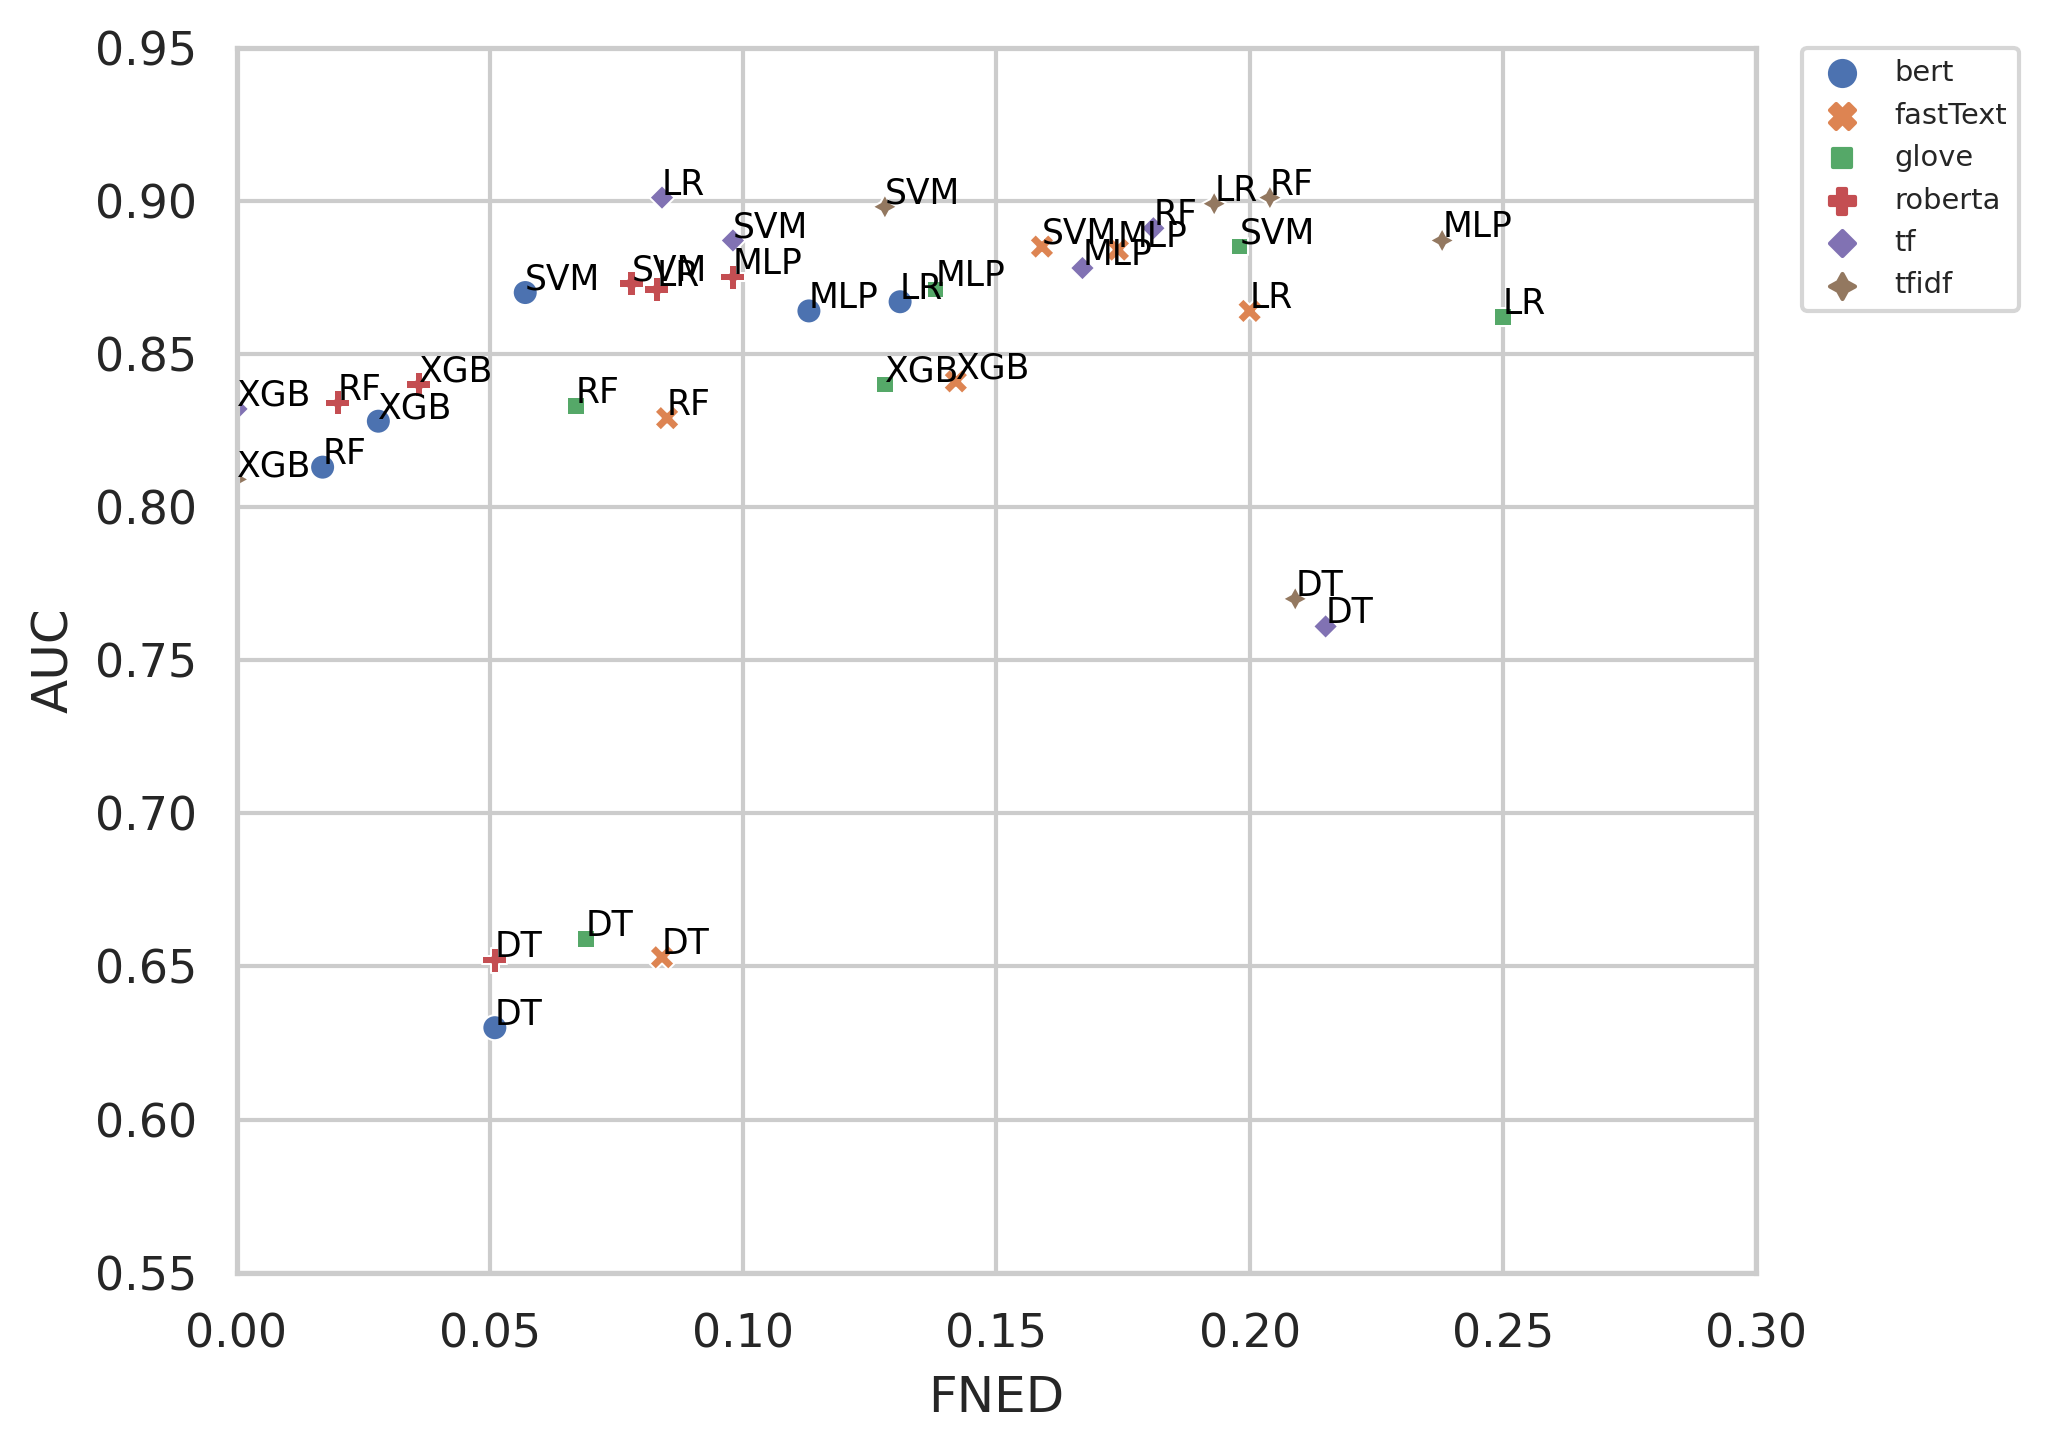

results/WH/plots


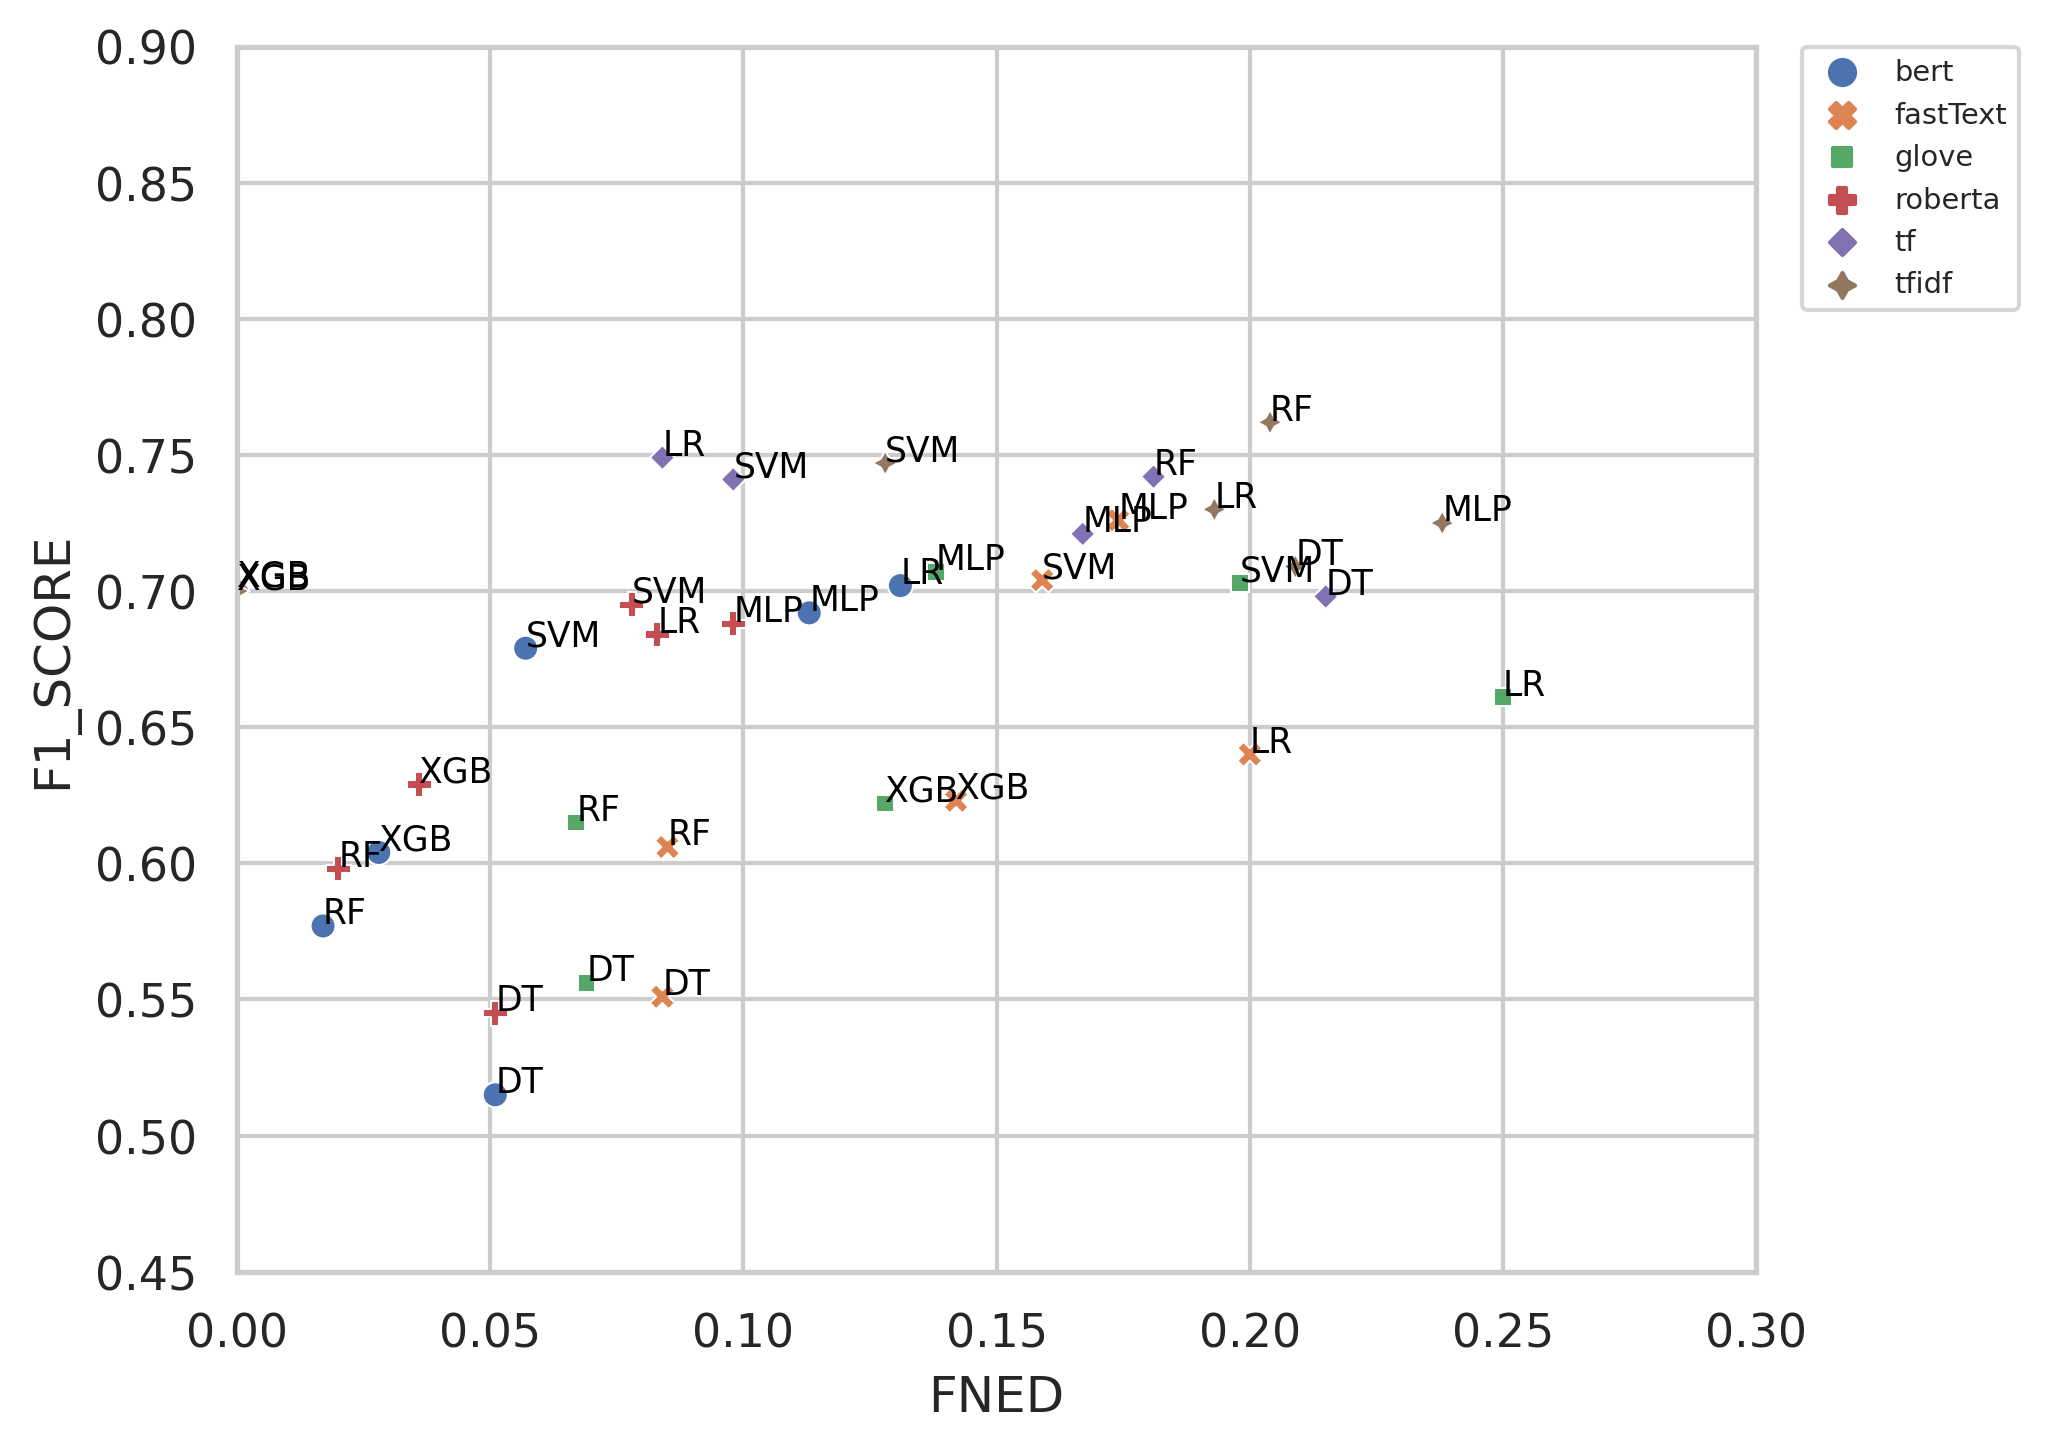

results/WH/plots


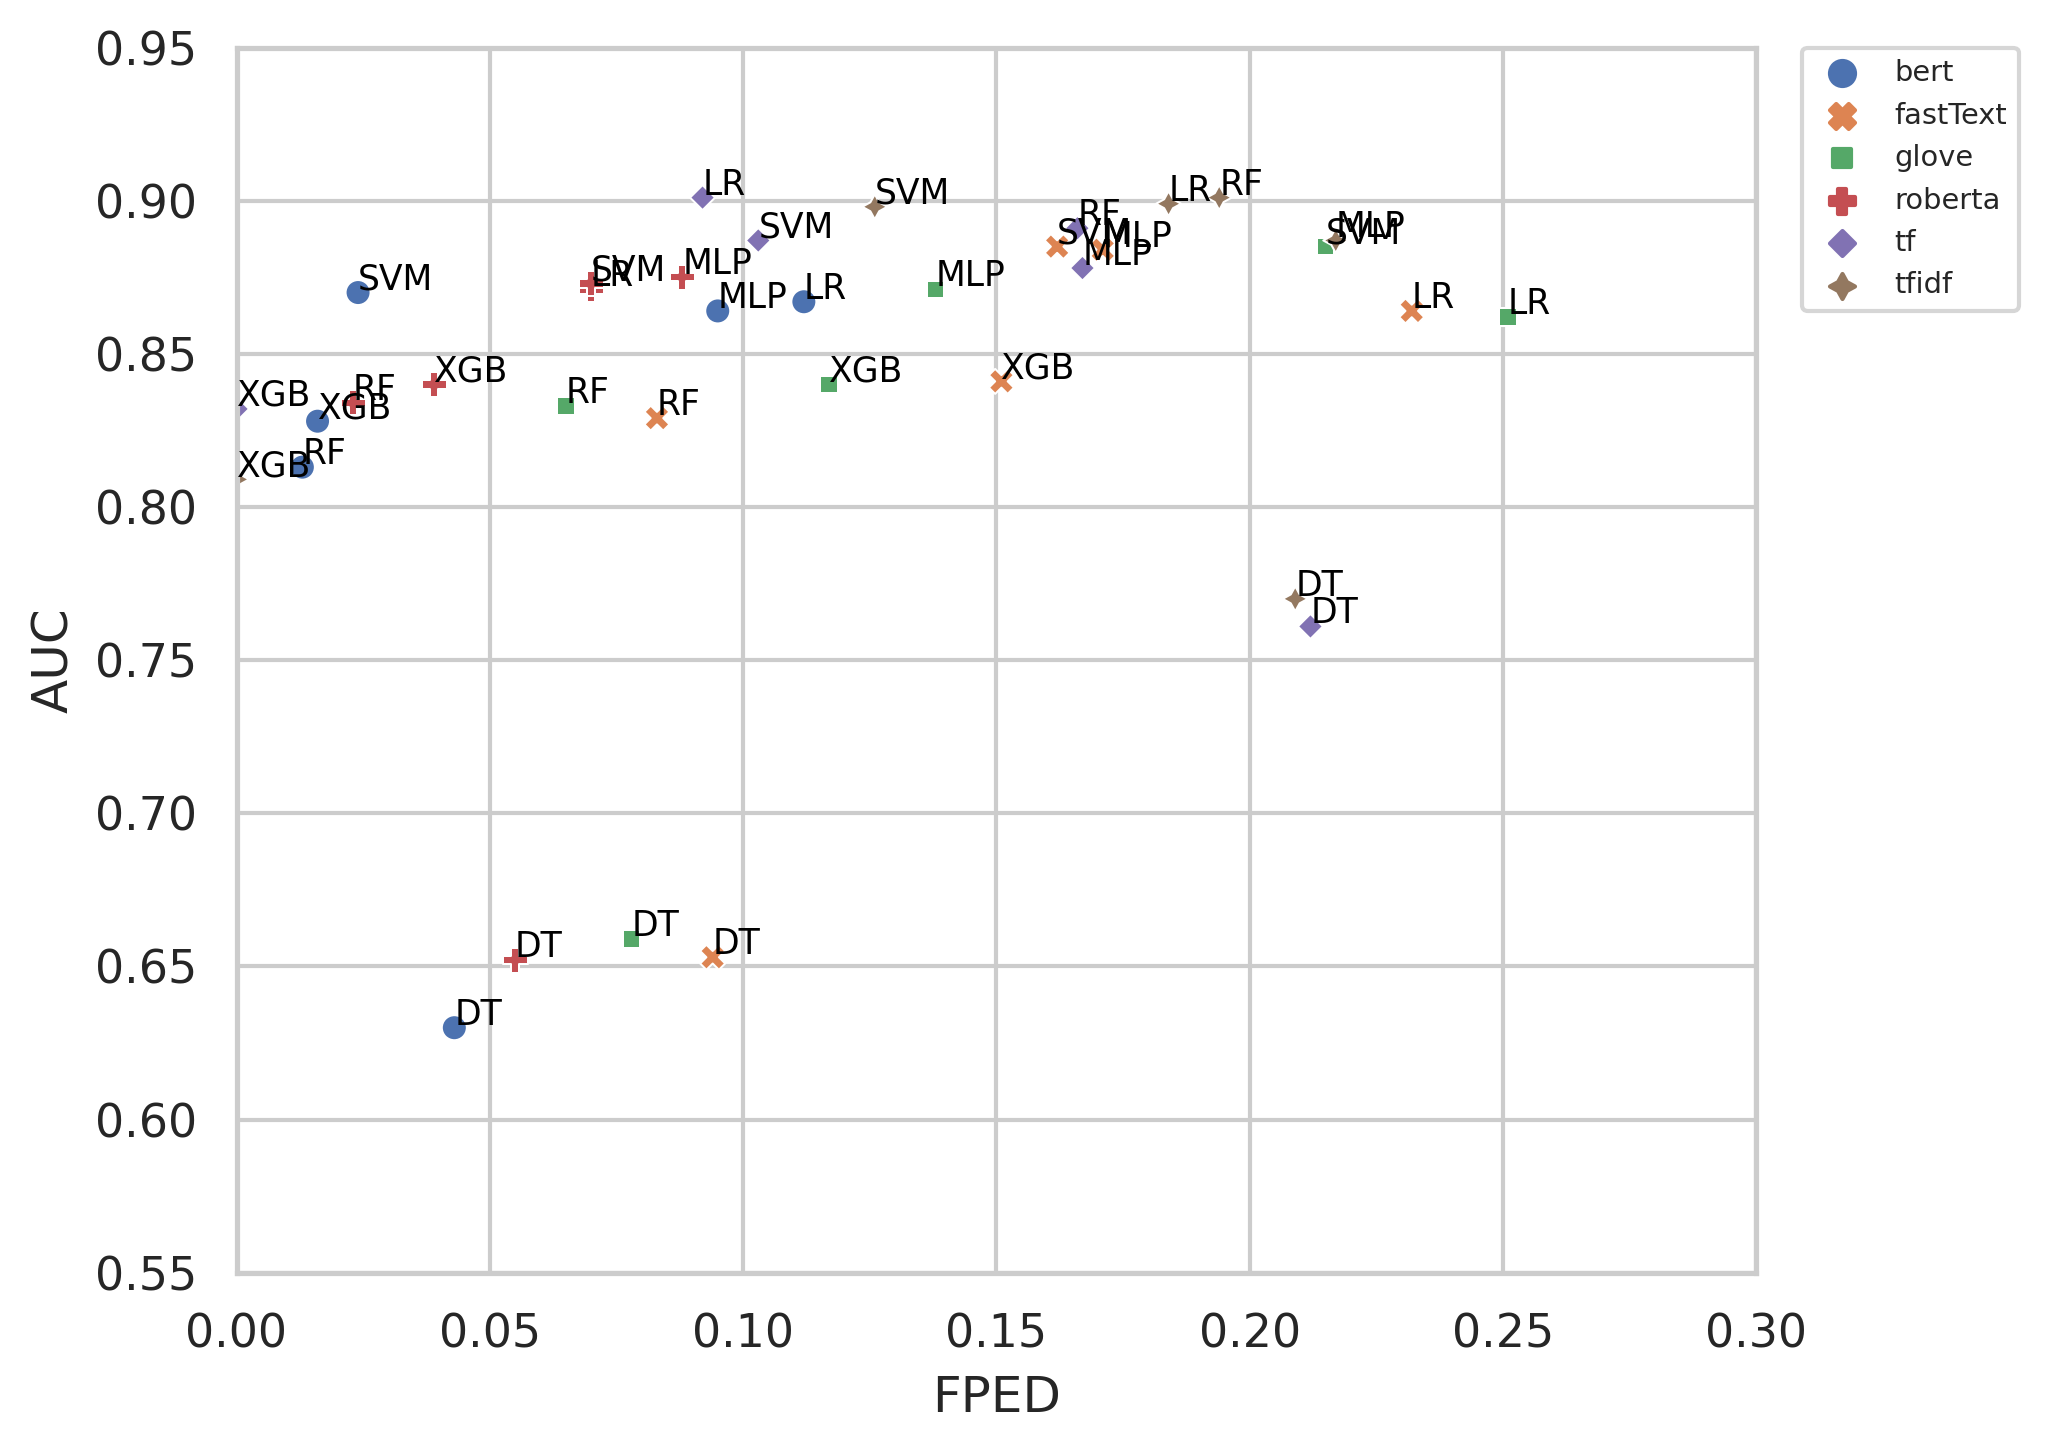

results/WH/plots


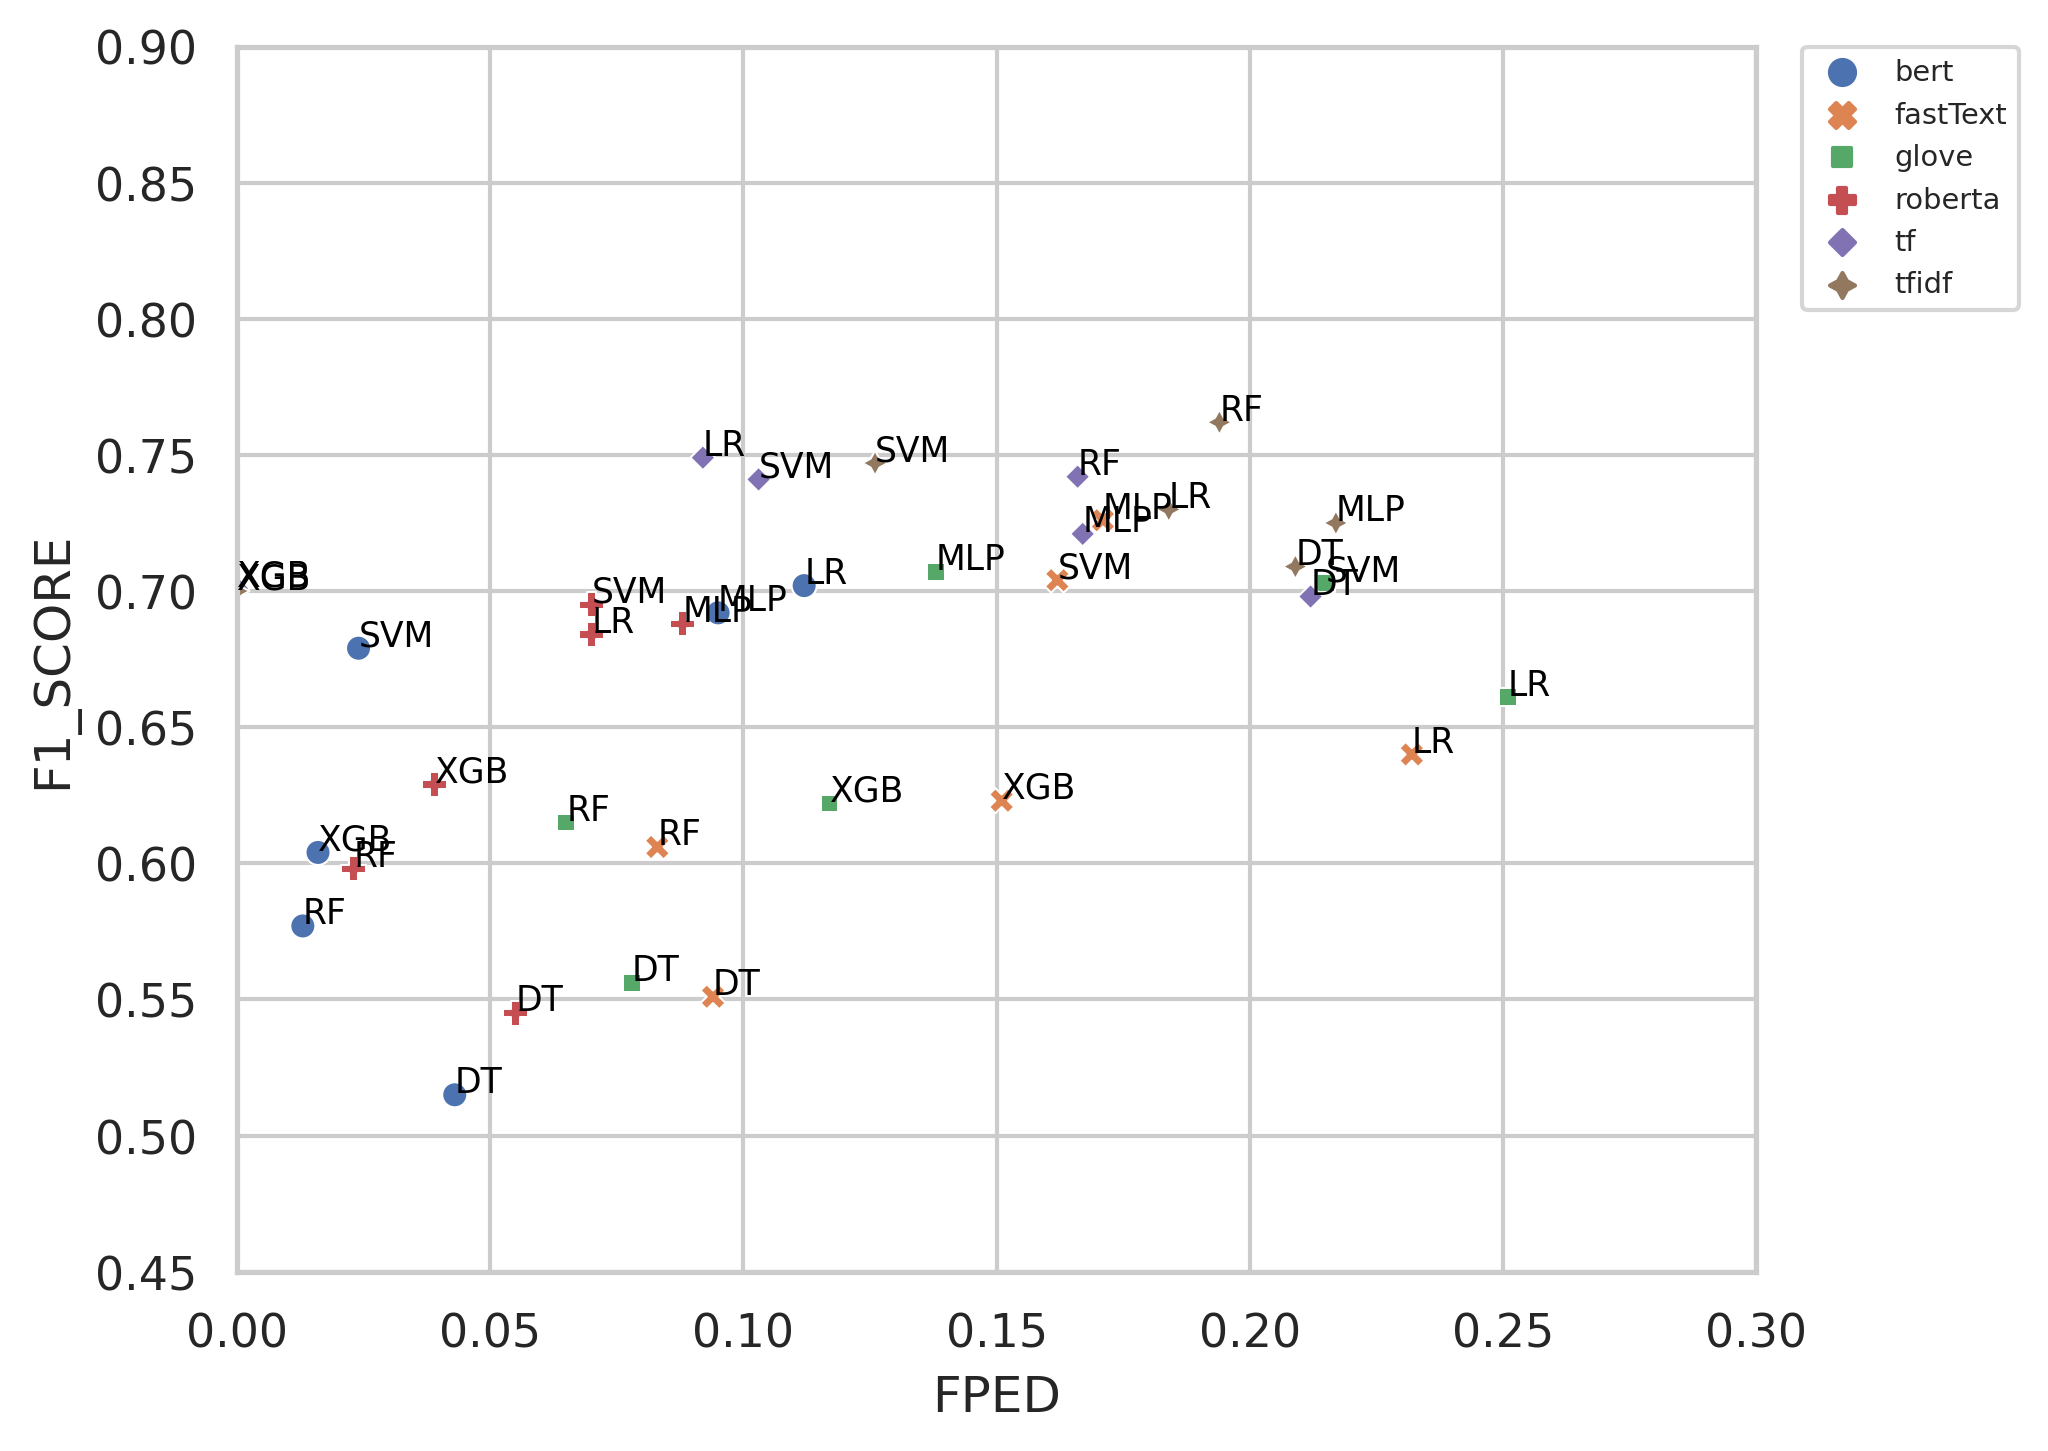

results/WH/plots


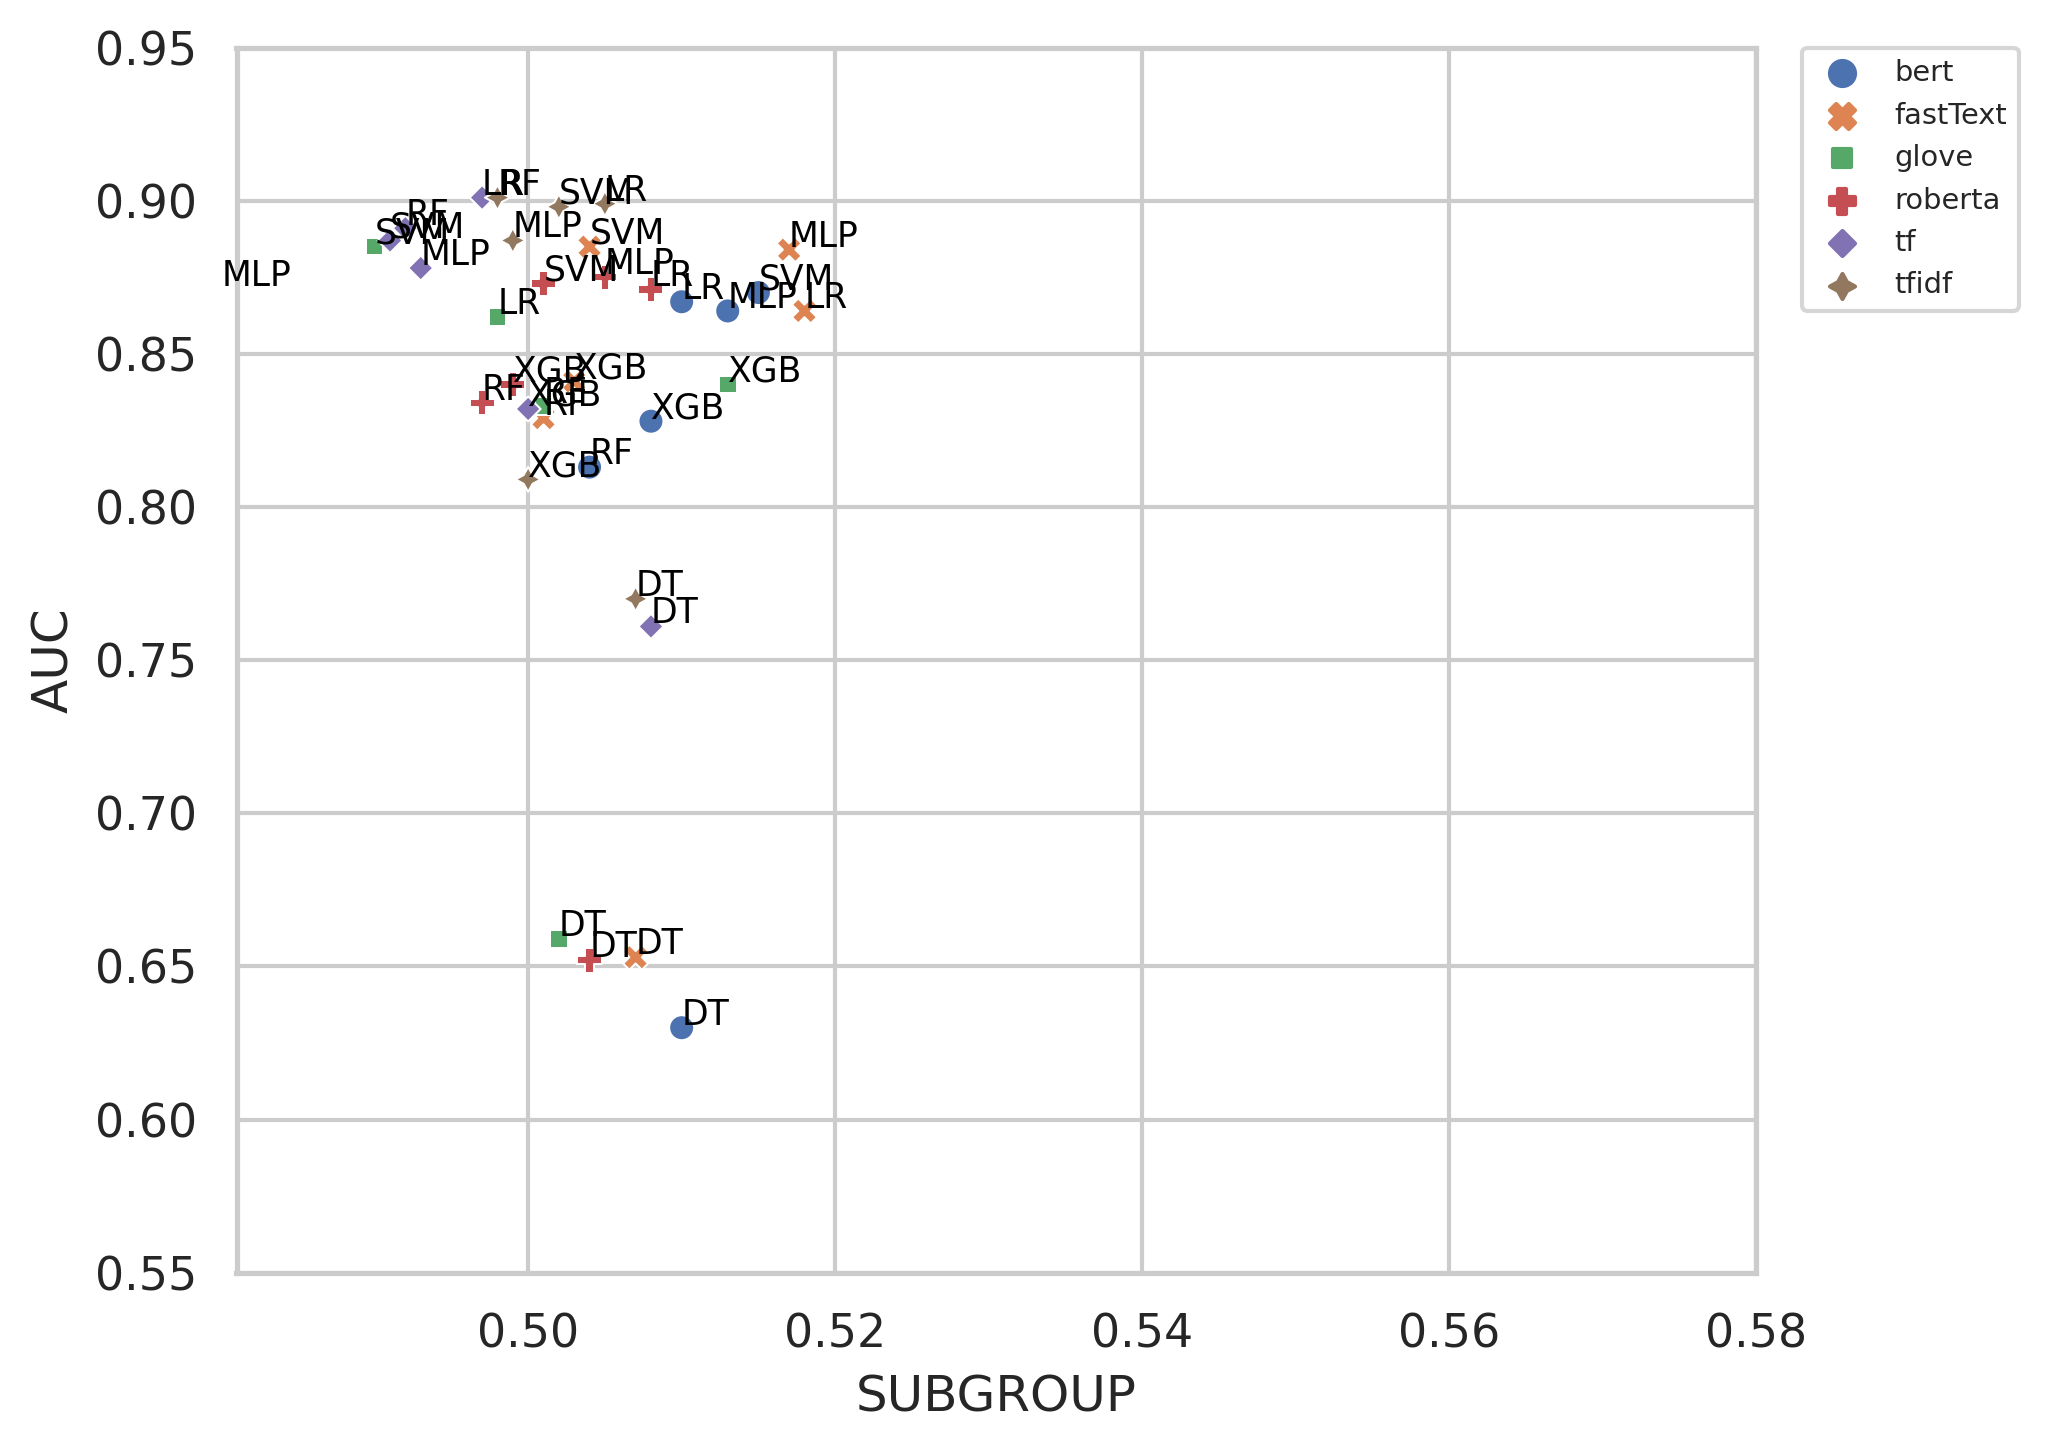

results/WH/plots


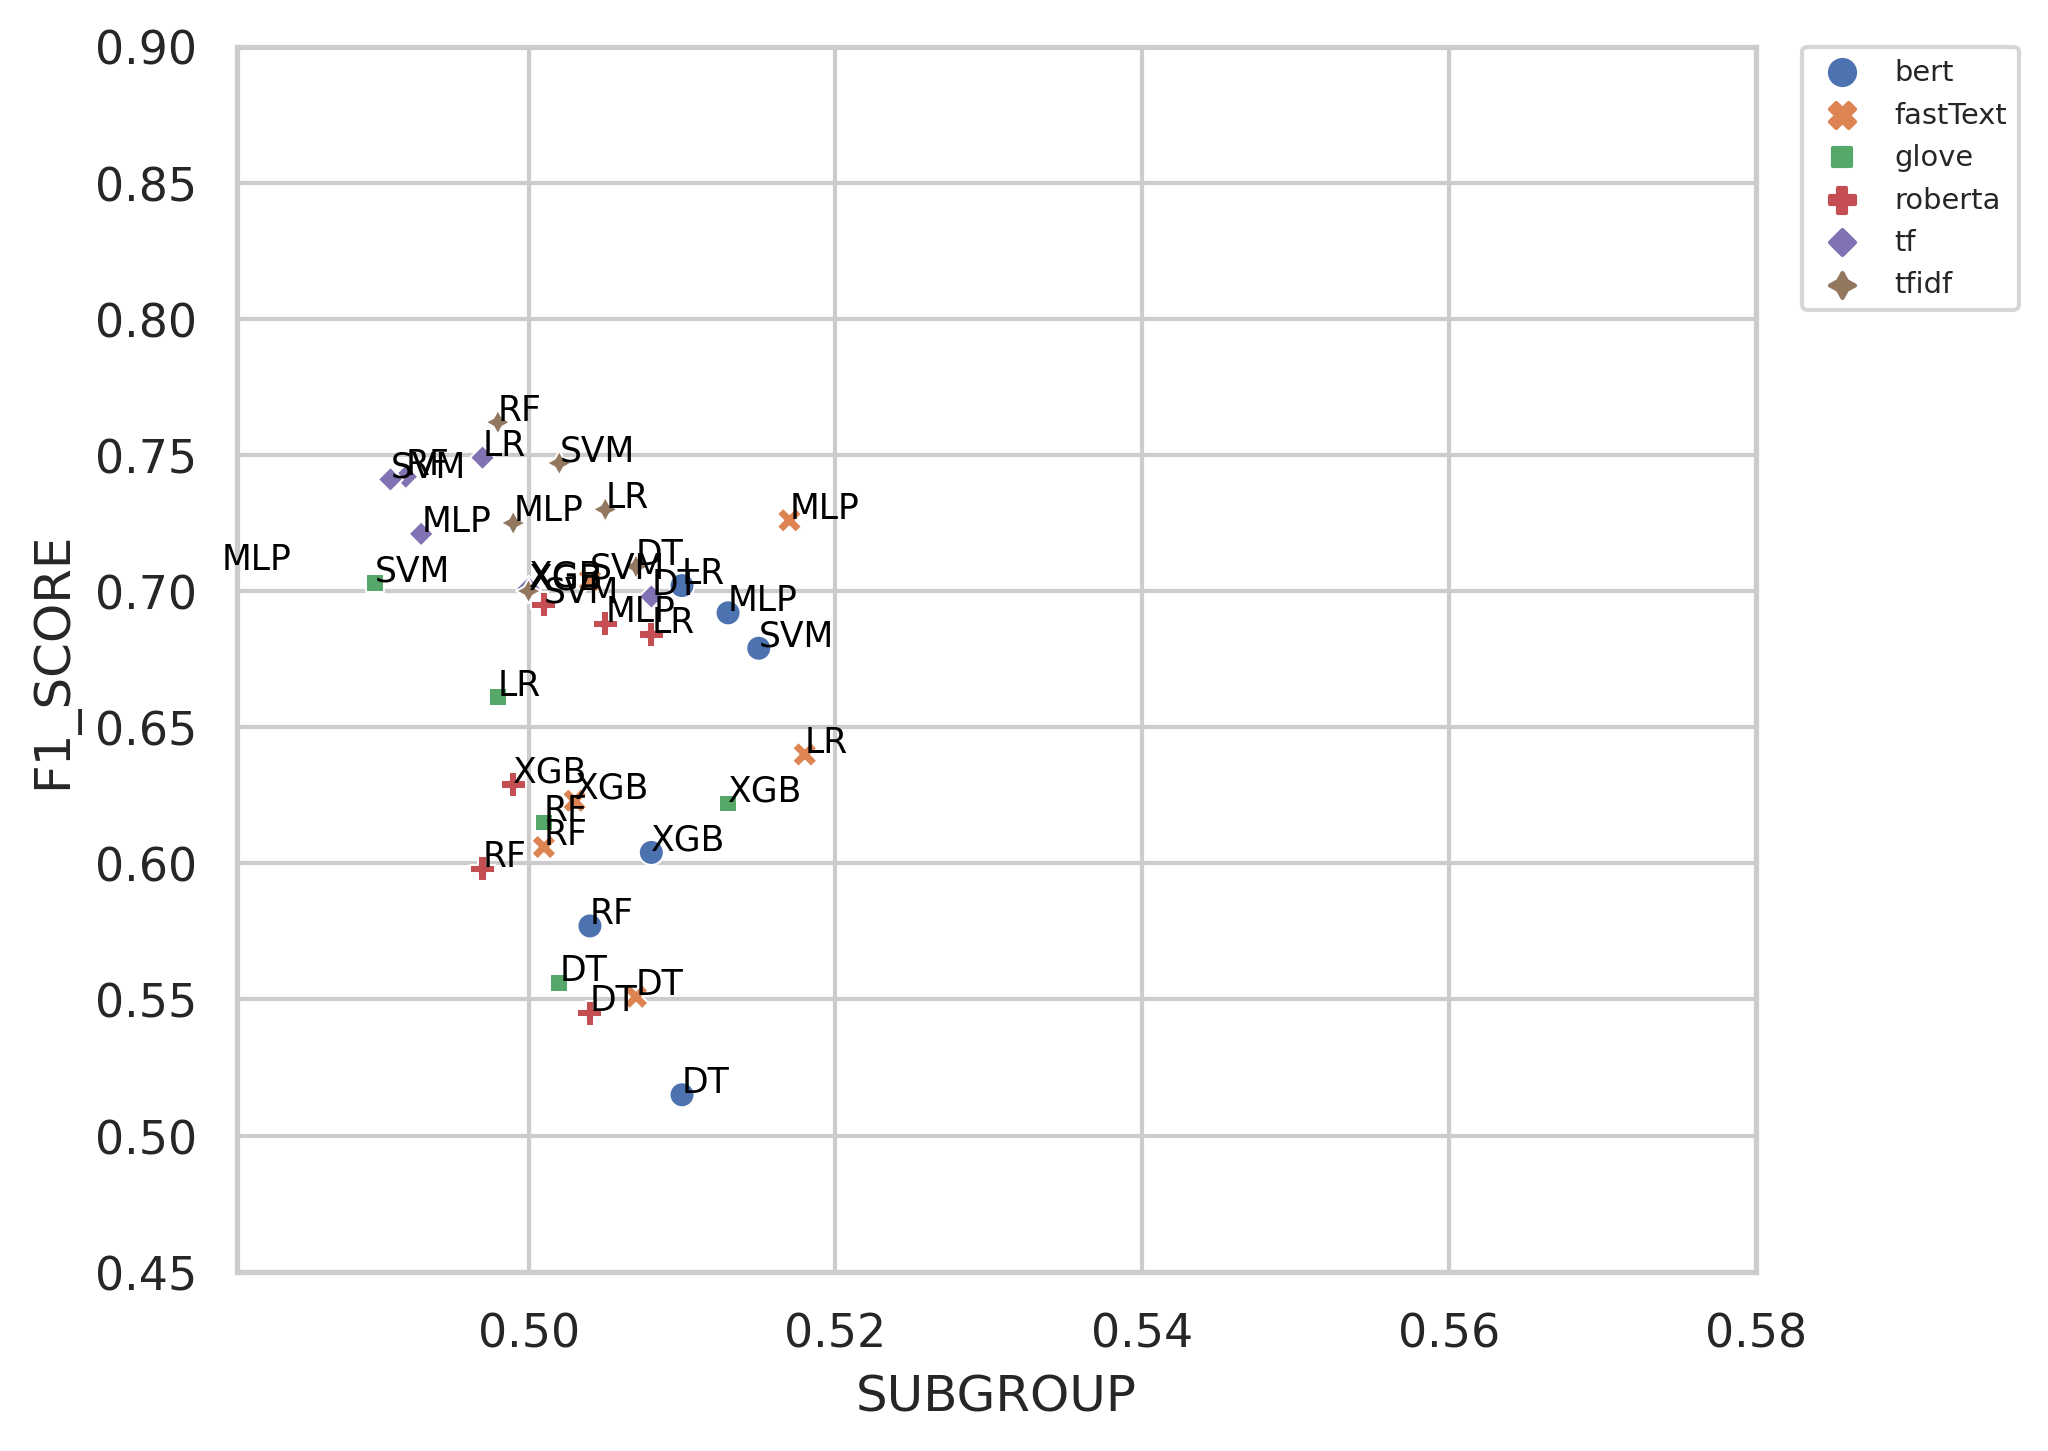

results/DV/plots


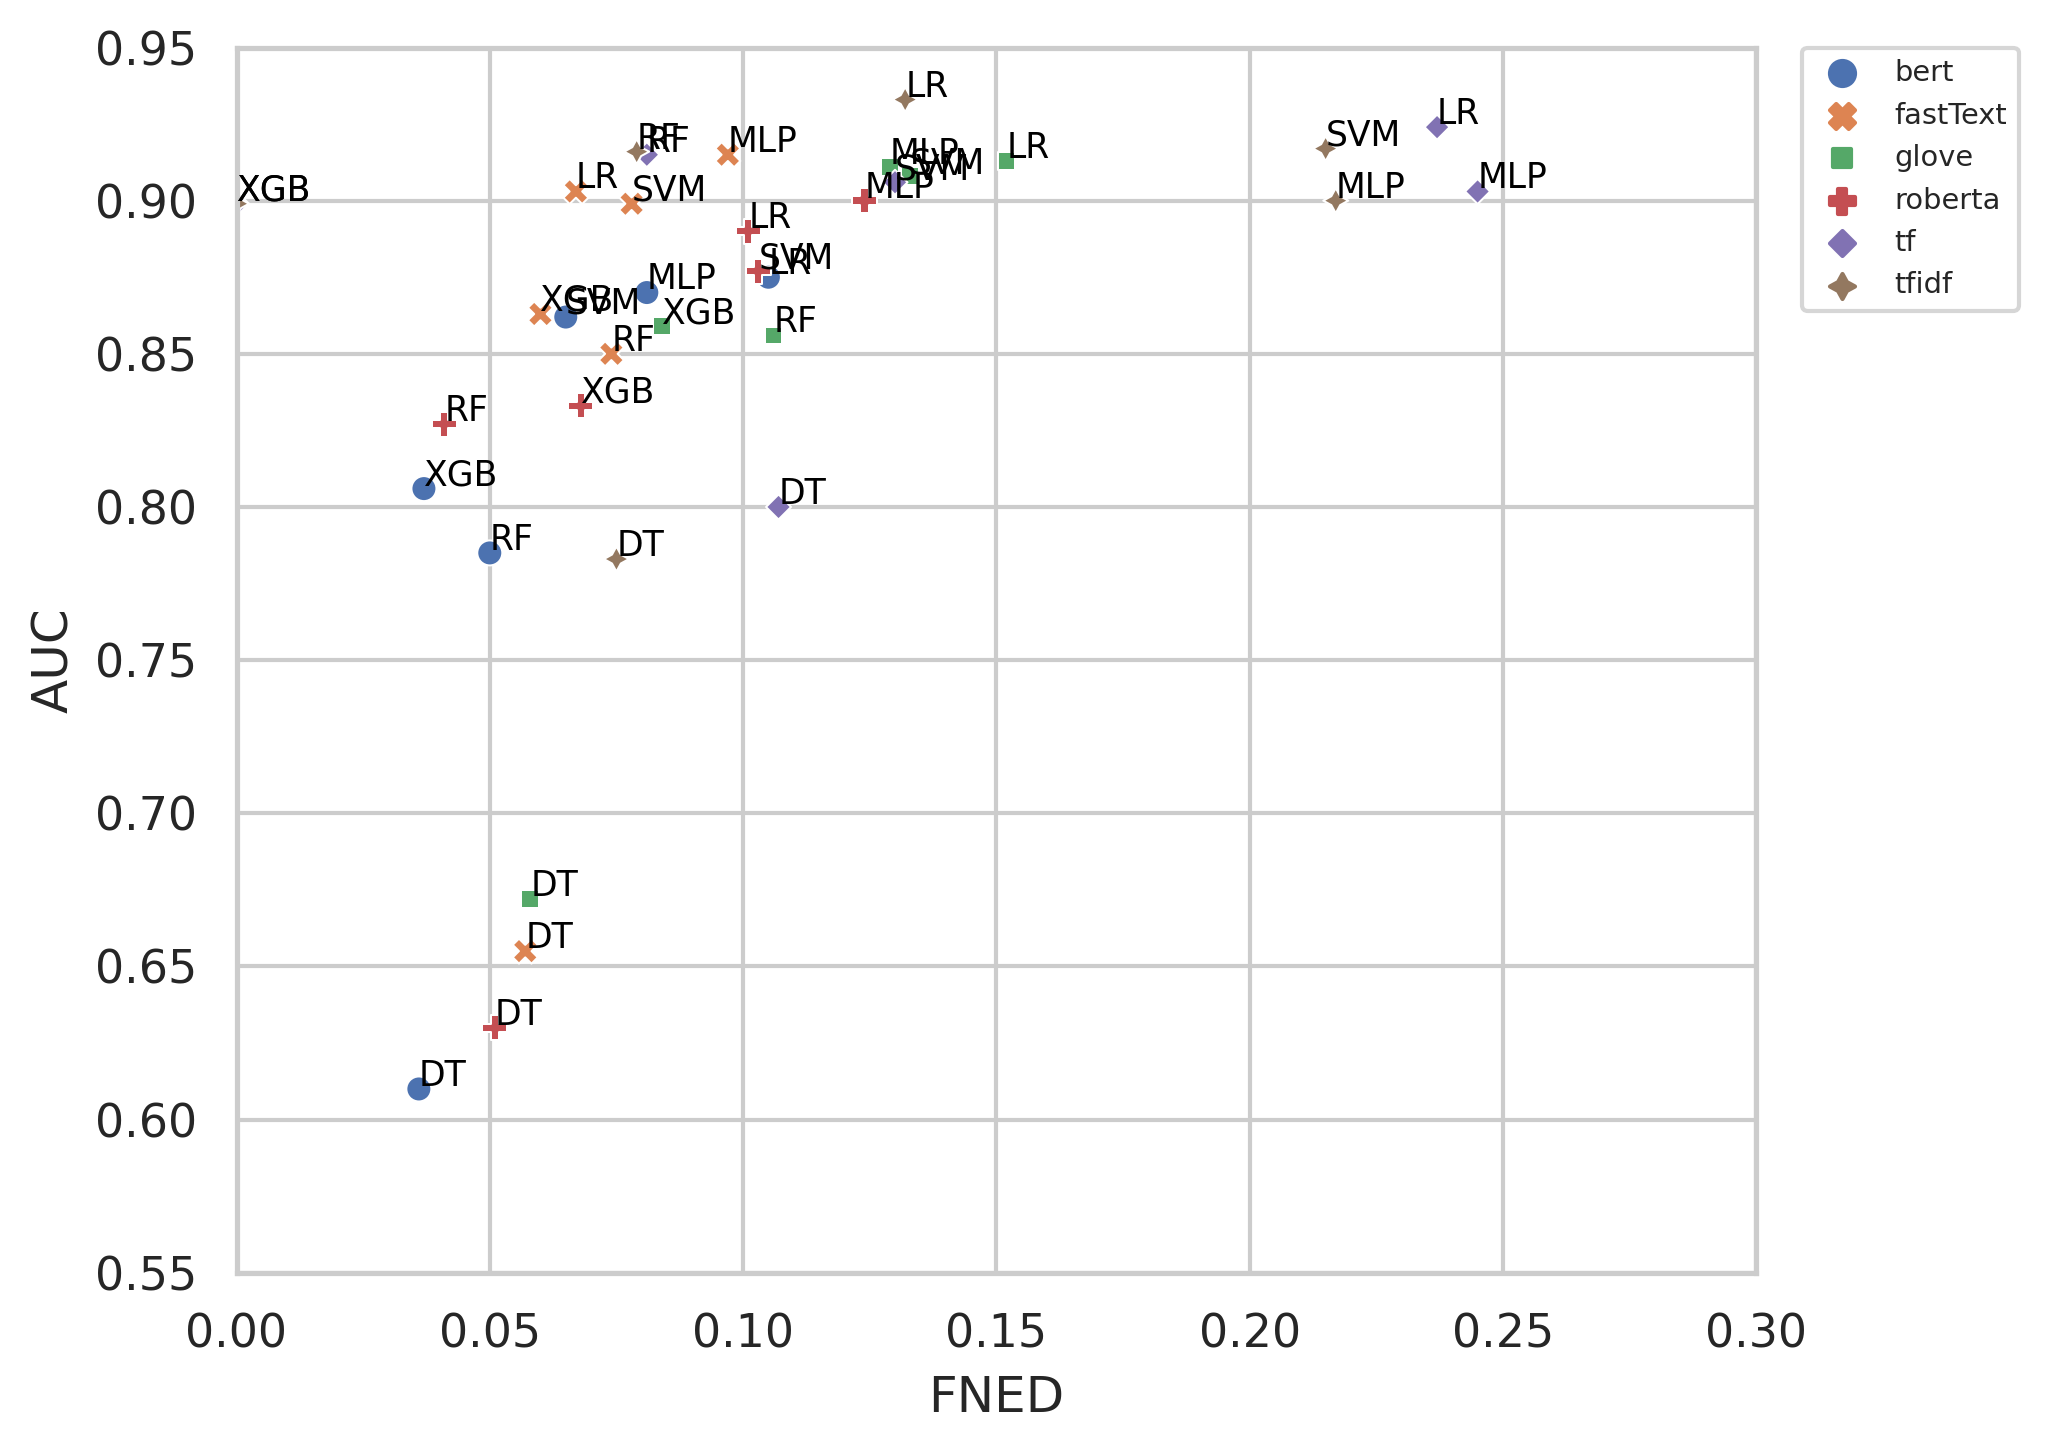

results/DV/plots


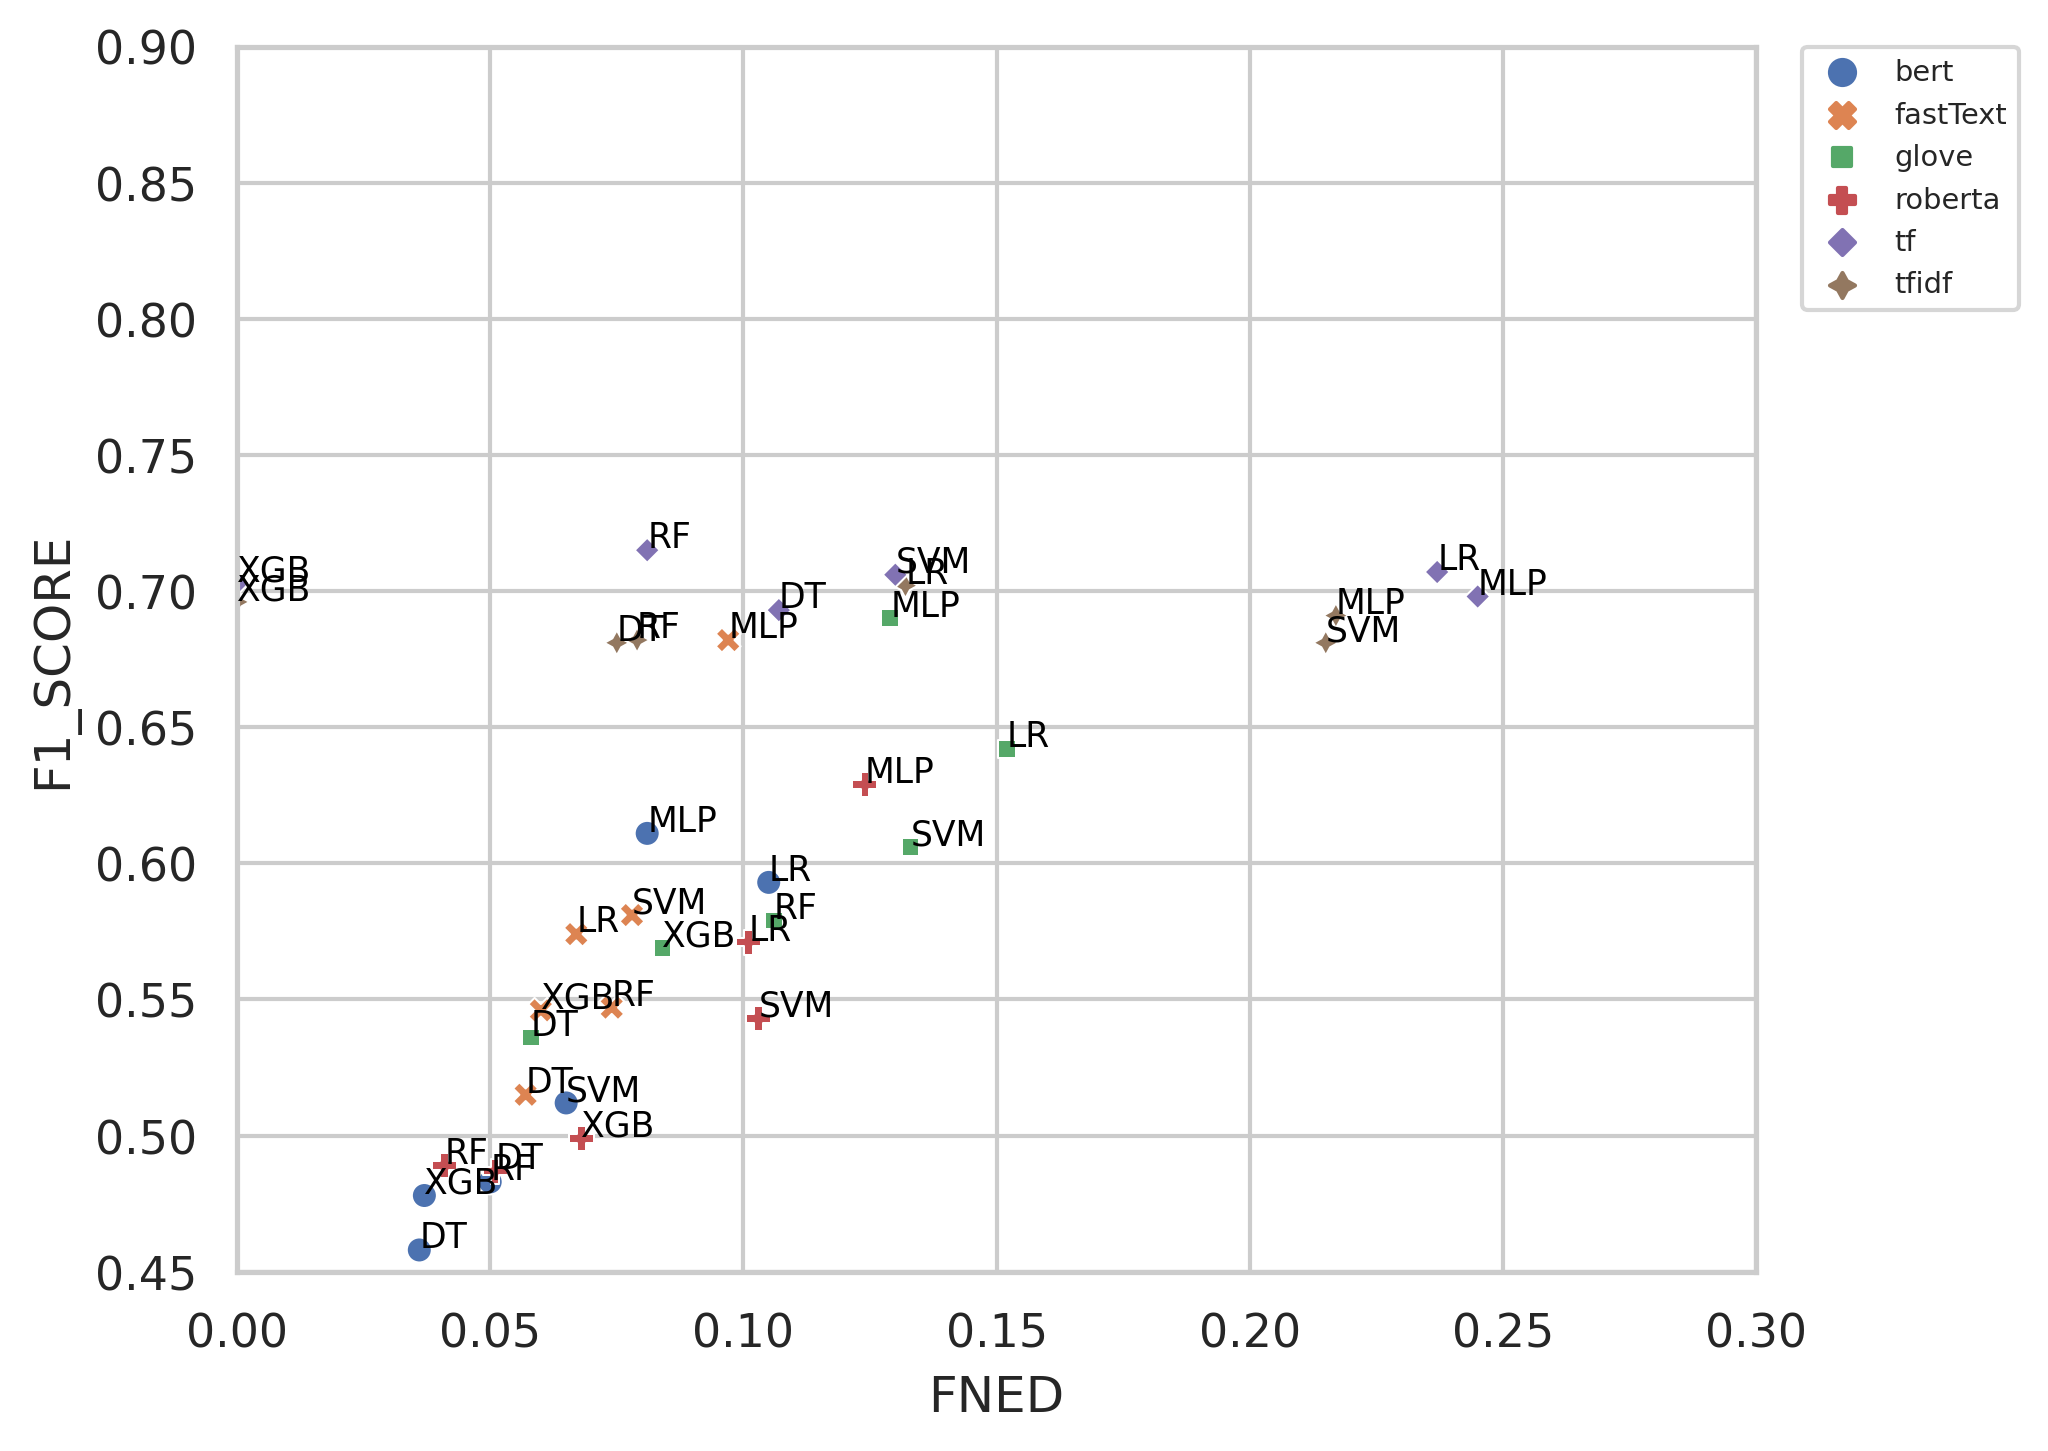

results/DV/plots


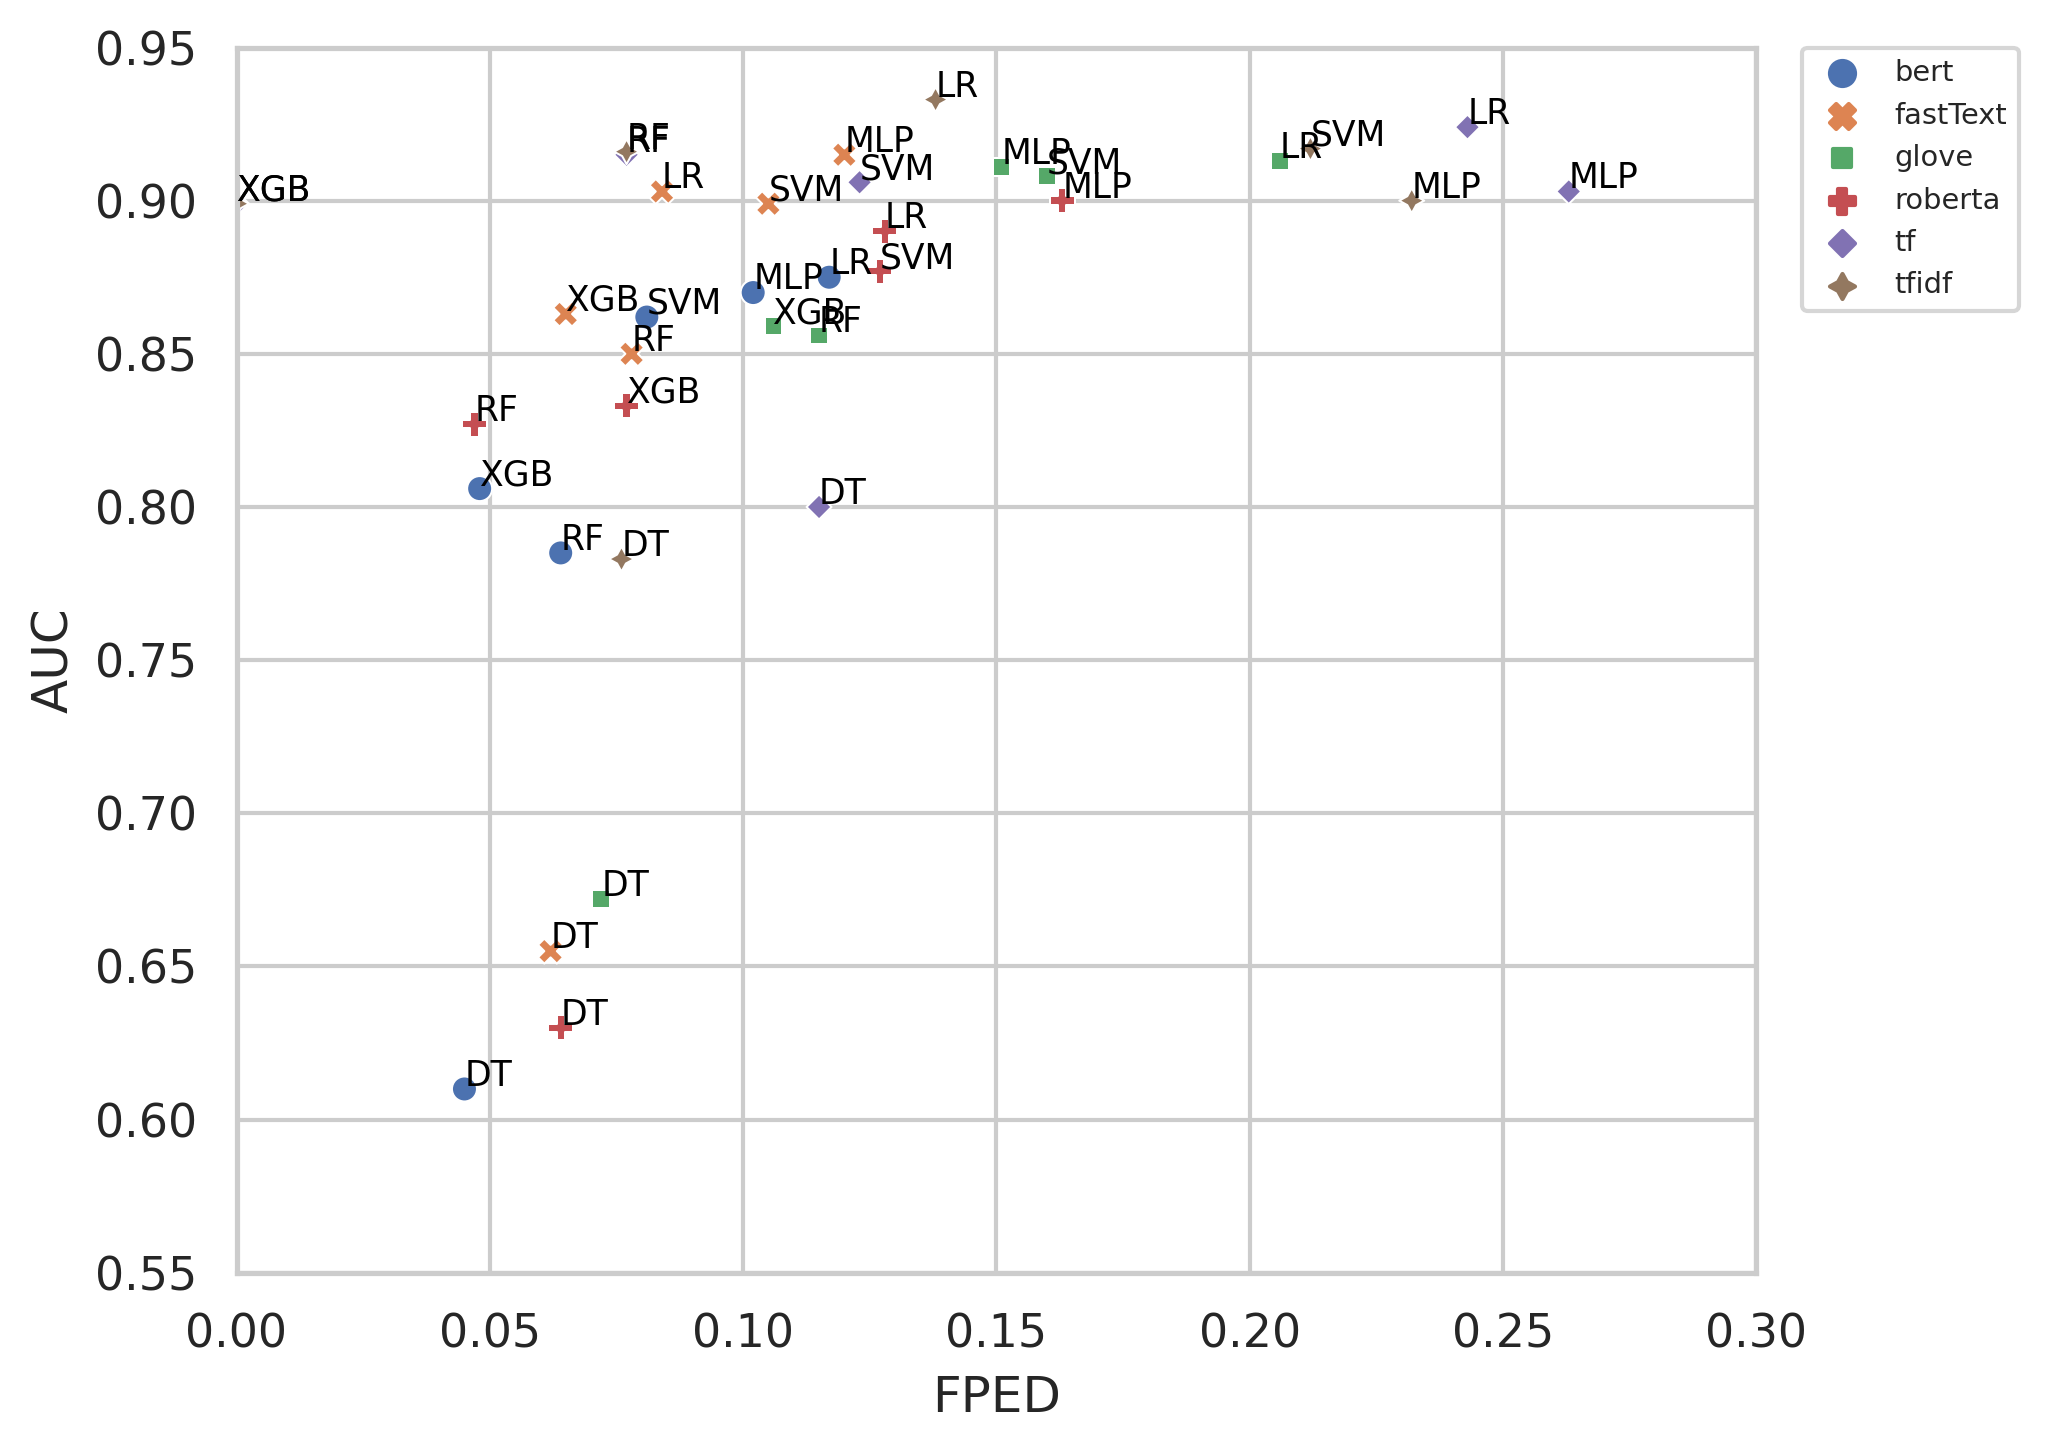

results/DV/plots


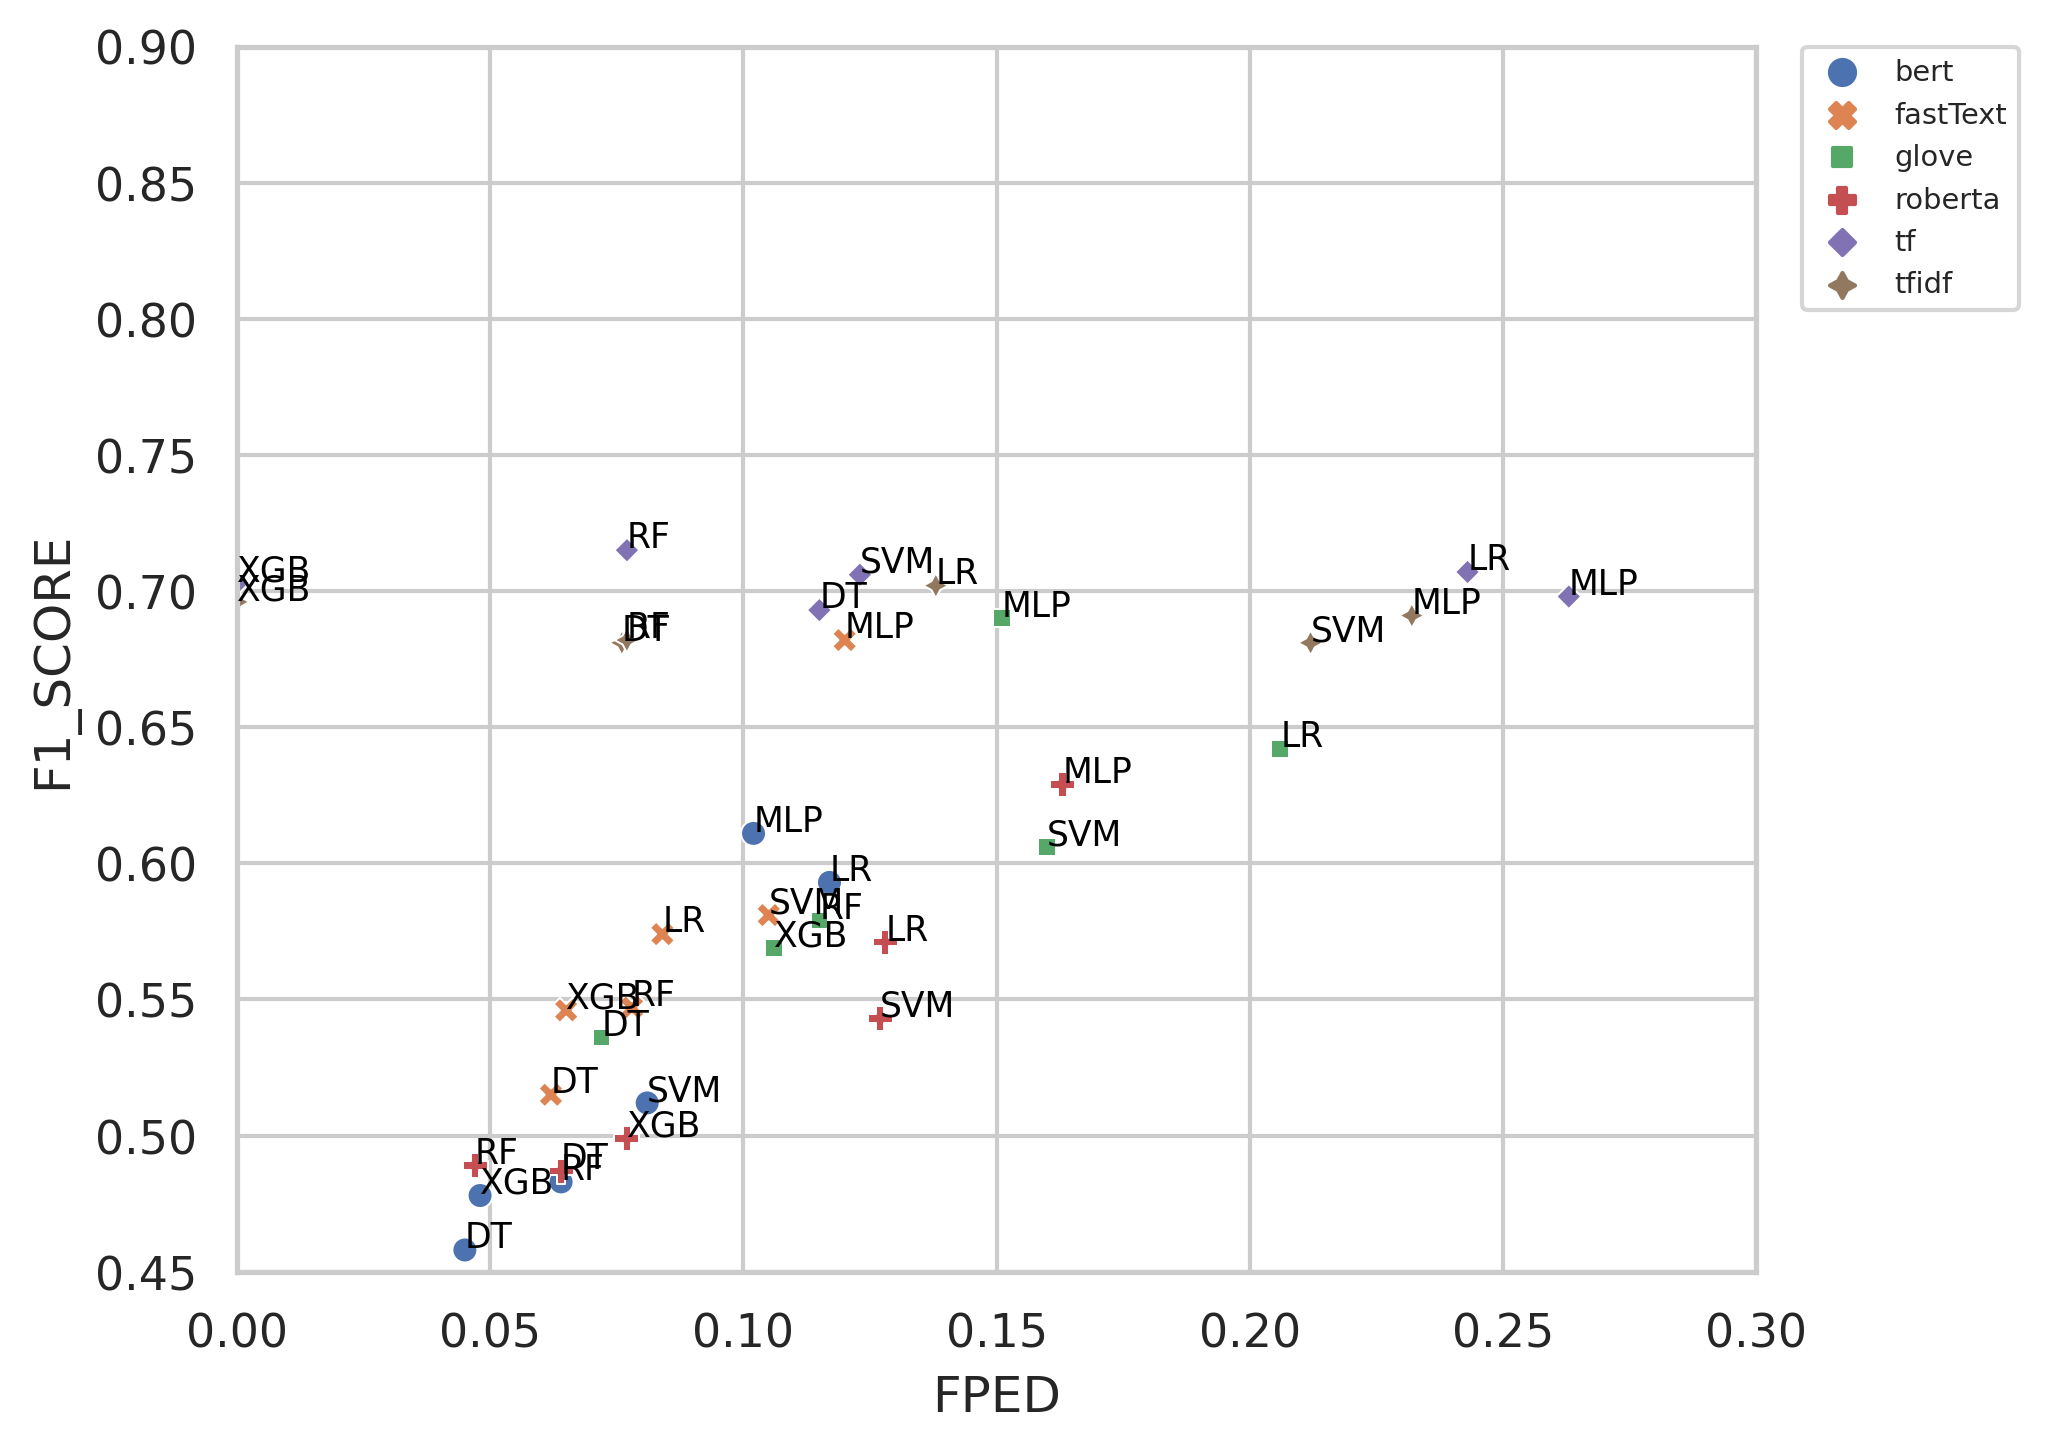

results/DV/plots


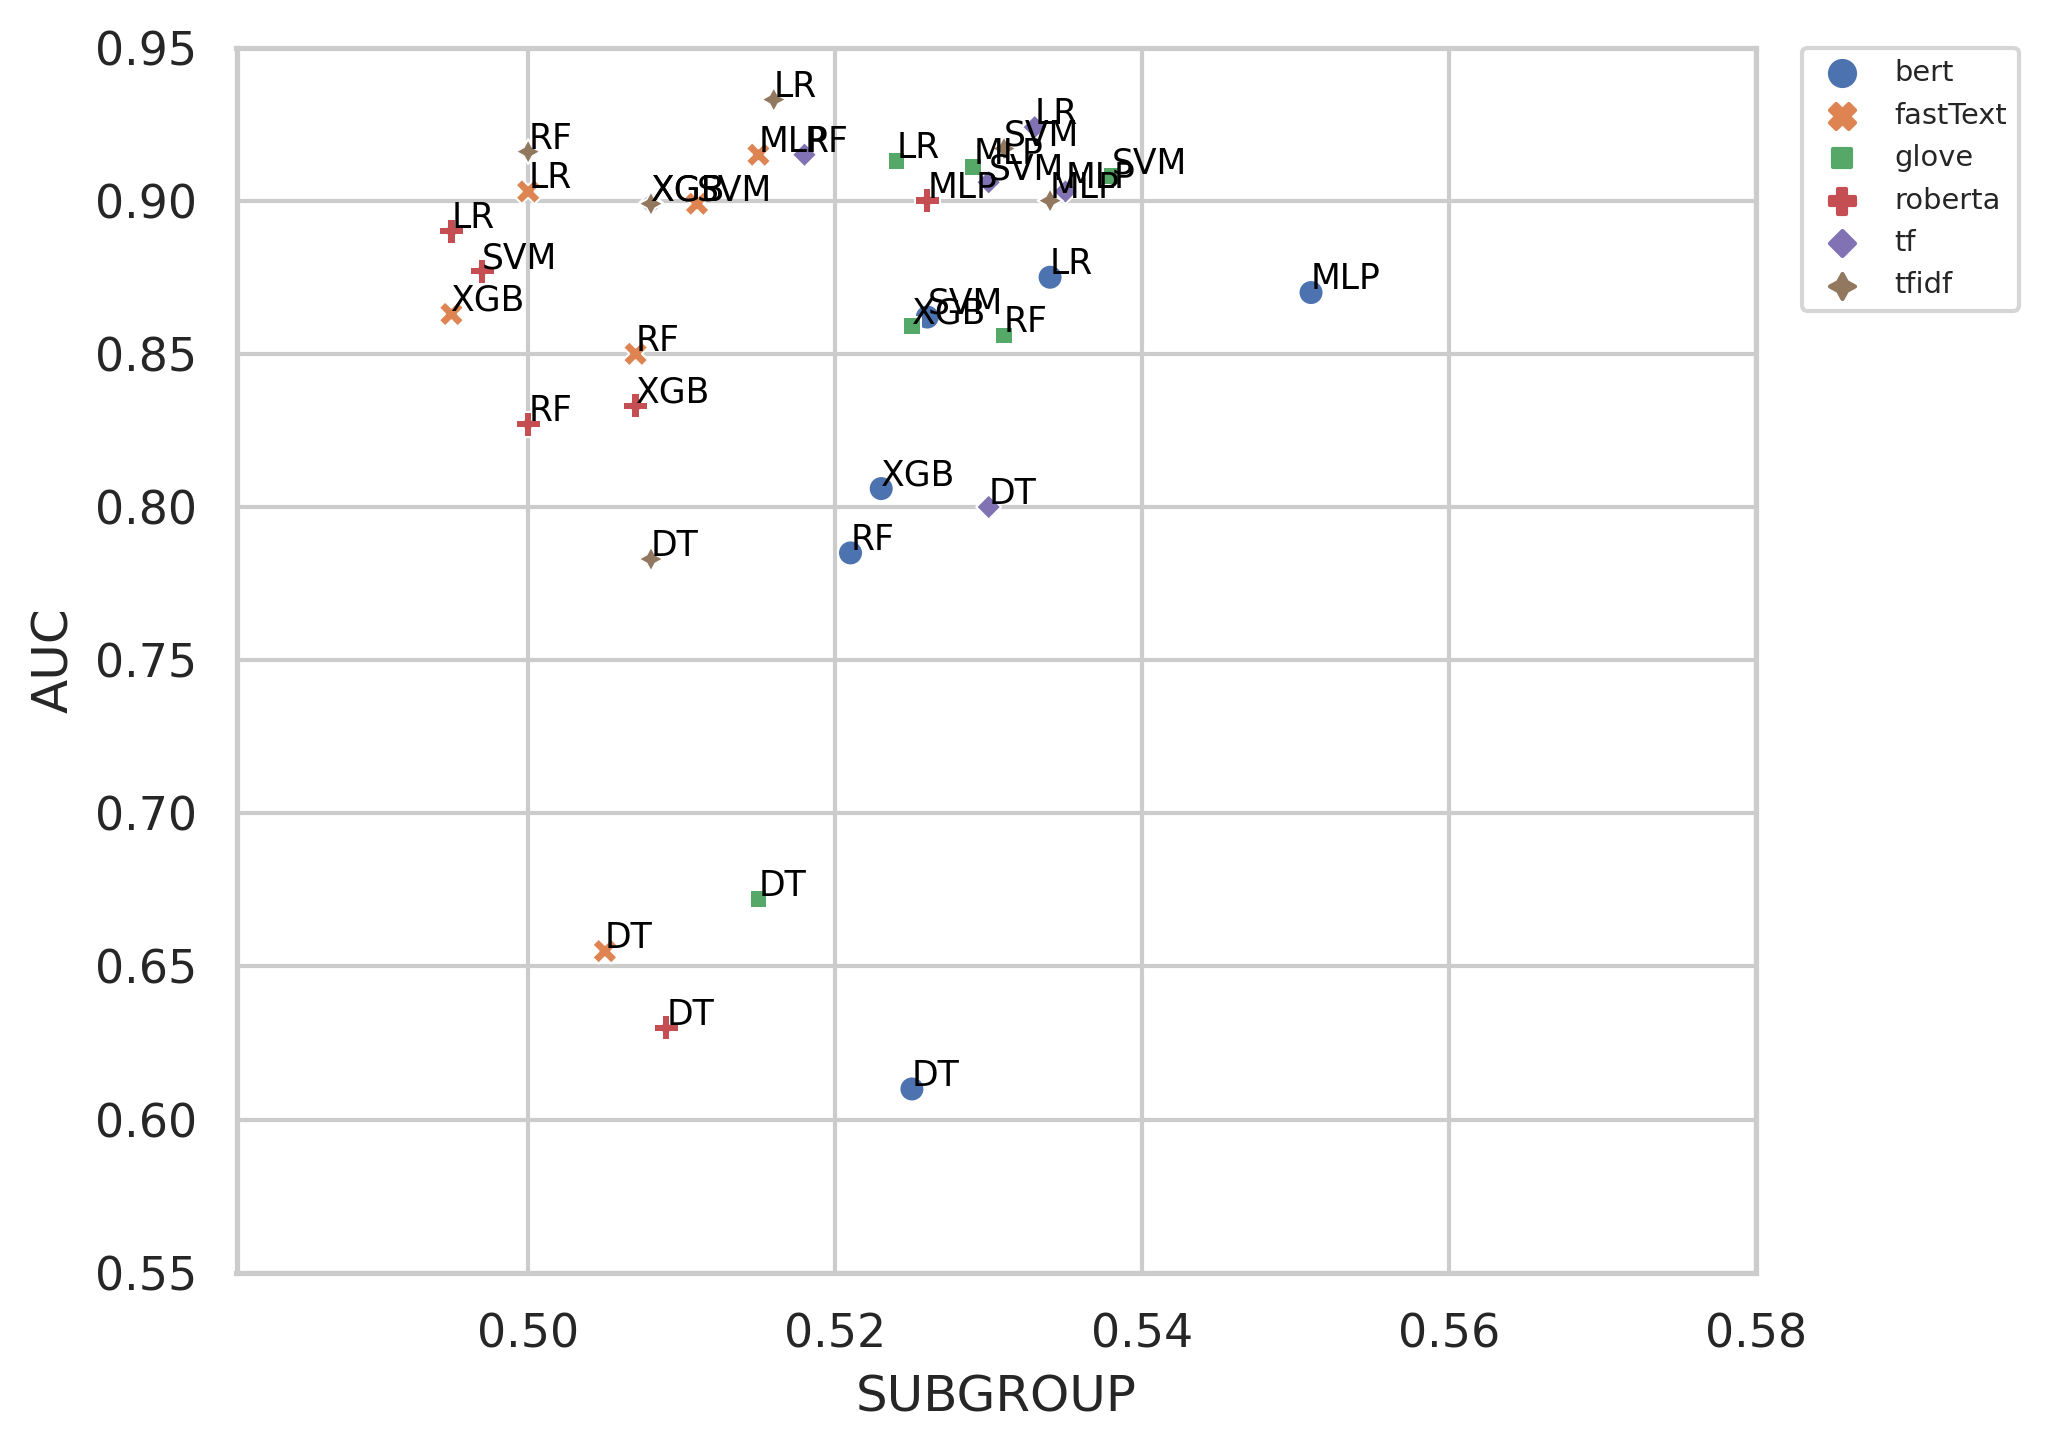

results/DV/plots


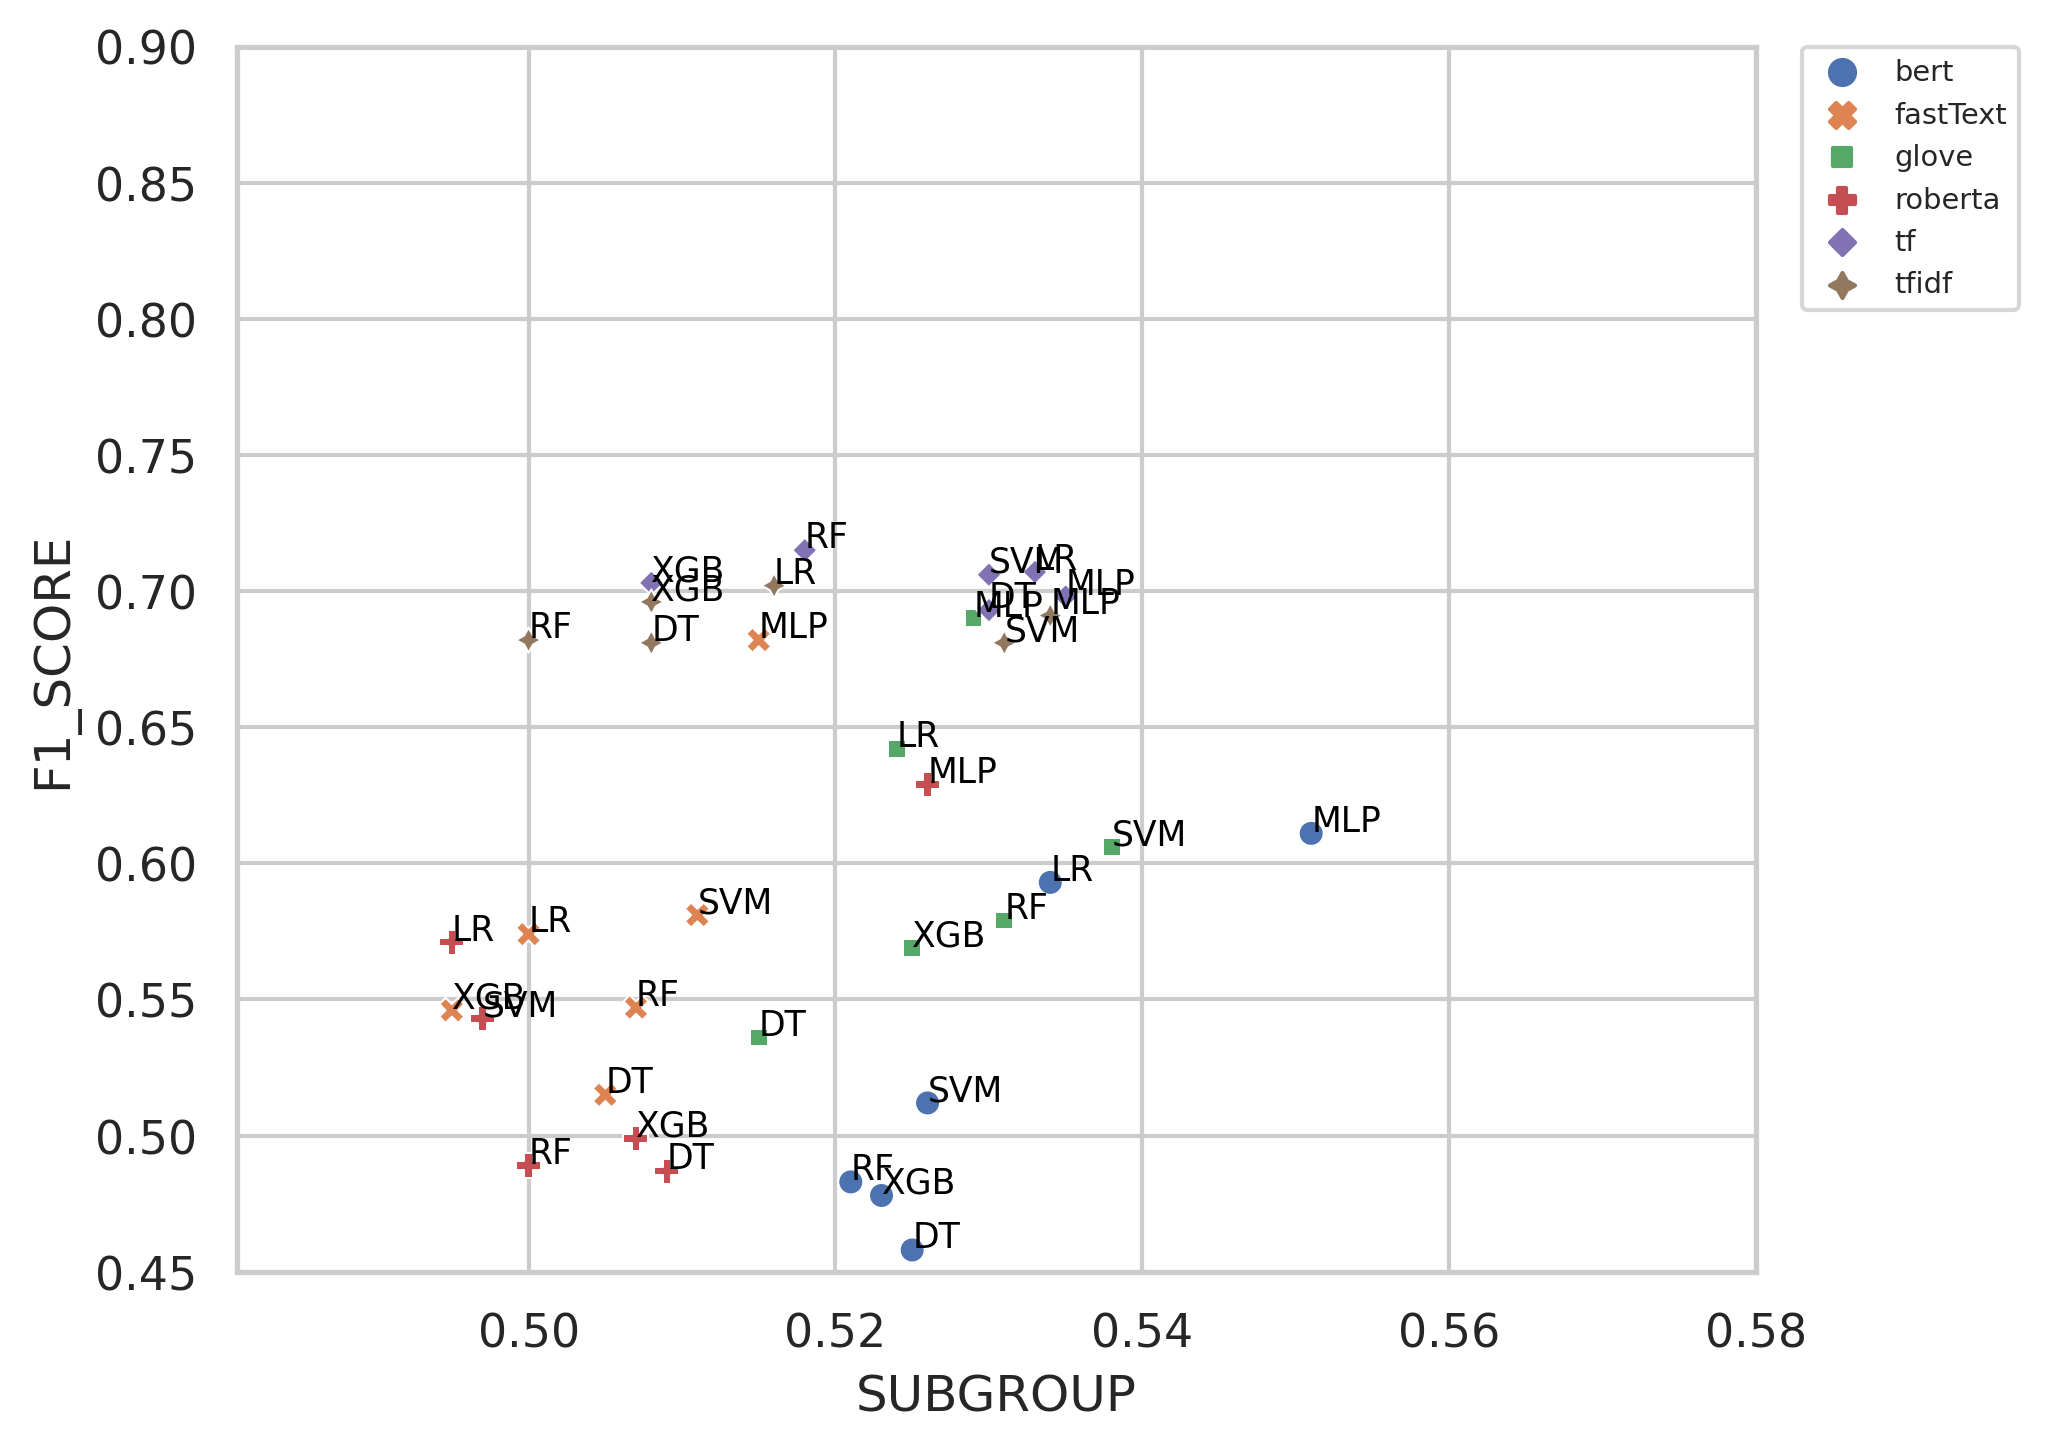

In [9]:
results ={}
for dataset in DATASETS:
    df = get_results_dataset(dataset_name = dataset)
    results[dataset] = df[df.classifier != "SVM_rbf"].reset_index()
    for metric1 in METRICS_BIAS:
        for metric2 in METRICS_CLASSIC:
            plot_pars(results[dataset],metric1=metric1, metric2=metric2, path=f"results/{dataset}/plots/{metric1}_{metric2}_{dataset.lower()}.pdf", 
                      title=dataset, labelsx=metric1.upper(), labely=metric2.upper())
    
# plot_wins_dataset(results,path="results/plot_wins.pdf")